# Loading necessary libraries

In [404]:
# Clear memory
%reset -f

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [474]:
# System imports
import sys
import importlib
from pathlib import Path

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Project setup
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Project modules
MODULES = [
    'iowa_dream.data',
    'iowa_dream.data.importer',
    'iowa_dream.data.loader', 
    'iowa_dream.utils.plotting_EDA',
    'iowa_dream.utils.describer',
    'iowa_dream.data.cleaner',
    'iowa_dream.utils.inconsistency_check'
]

# Reload modules
for module in MODULES:
    if module in sys.modules:
        importlib.reload(sys.modules[module])
    else:
        __import__(module)

# Project imports
from iowa_dream.data.importer import load_config
from iowa_dream.data.loader import preliminary_loader
from iowa_dream.utils.describer import (
    categorical_describer,
    numerical_describer, 
    analyze_categorical_sparsity
)
from iowa_dream.utils.plotting_EDA import (
    plot_missing_data_heatmap,
    box_plot_dist,
    output_distribution_plotting,
    plot_target_over_time,
    plot_feature_distributions_interactive,
    plot_feature_target_relationships_interactive,
    plot_price_vs_sale_condition,
    plot_cramer_v_associations,
    anova_categorical_feature_importance,
    plot_numerical_correlation_matrix
)
from iowa_dream.data.cleaner import (
    simple_fill_missing_by_keywords,
    garage_imputer,
    type_formatting
)
from iowa_dream.utils.inconsistency_check import (
    report_inconsistent_years,
    consistency_missing_type_area
)

# 0. Preliminary Load the Cleaned Data

In [477]:
# Example usage
data_file = project_root / load_config()['kaggle']['download_path'] / 'AmesHousing.csv'
# In this loader, we have standardized column names by replacing spaces with underscores, 
# converting to lowercase, 
# and applying specific replacements such as 'yr' to 'year', 
# 'qual' or 'qc' to 'qu' (quality), 
# 'abvgrd' to 'abvgr' (above grade), and 
# 'built' to 'blt' (built).
df = preliminary_loader(data_file)

In [476]:
# Extract feature column names for different data types
data_dict = load_config()['data_dict']
ordinal = data_dict['ordinal_columns']['columns']
nominal = data_dict['nominal_columns']['columns']
continuous = data_dict['continuous_columns']['columns']
discrete = data_dict['discrete_columns']['columns']

#1. Some EDAs on the Target of `saleprice`

In [408]:
numerical_describer(df, ['saleprice'])


Numerical Columns Summary:
Total numerical columns: 1
Columns with missing values: 0


Total Missing  Percent Missing Data Type  \
saleprice              0              0.0     int64   

                                     Value Information           Mean  \
saleprice  Range: 12789 to 755000 (1032 unique values)  180796.060068   

                Std Dev    Min       25%       50%       75%     Max  
saleprice  79886.692357  12789  129500.0  160000.0  213500.0  755000

Comment: No missing values but seems to disperse a lot. 


Price Range Distribution (%):
saleprice
<$100k          8.6
$100k-$200k    62.2
$200k-$300k    21.4
$300k-$400k     5.7
>$400k          2.2

Normality Tests (α = 0.1):
              Test  Test Statistic       p-value    Result
D'Agostino-Pearson     1074.646596 4.400040e-234 Reject H₀
      Shapiro-Wilk        0.876261  2.334909e-43 Reject H₀
  Anderson-Darling       87.367435           NaN Reject H₀
       Jarque-Bera     4668.421409  0.000000e+00 Reject H₀

Fat-Tailed Tests (α = 0.1):
    Test  Test Statistic  Reference Value     Result
Kurtosis        8.108122              3.0 Fat-tailed


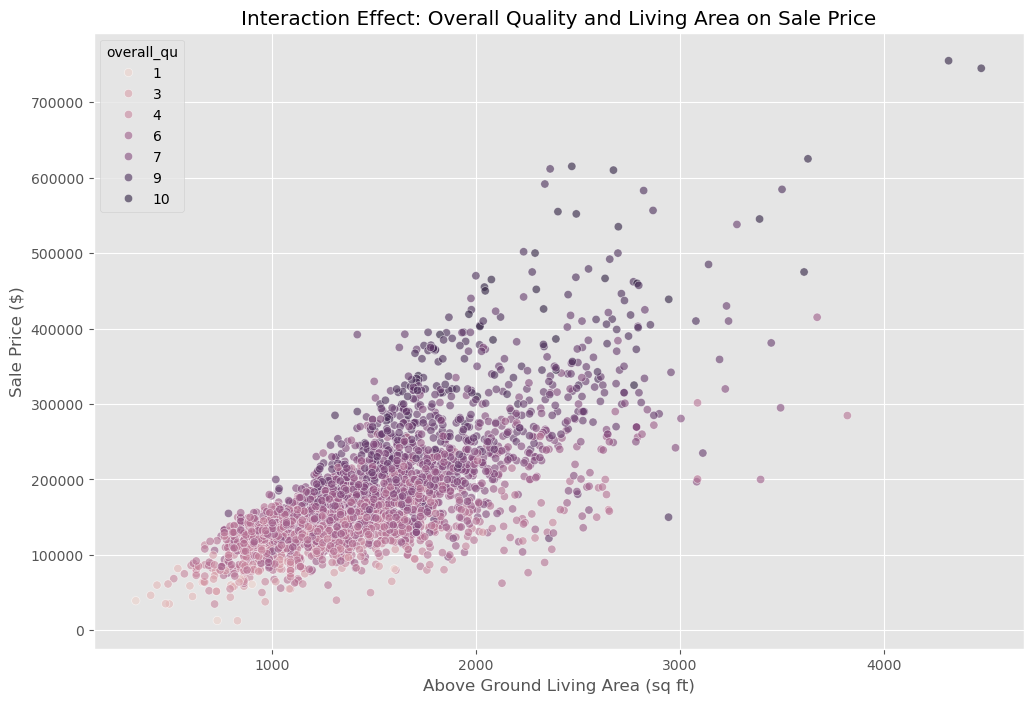

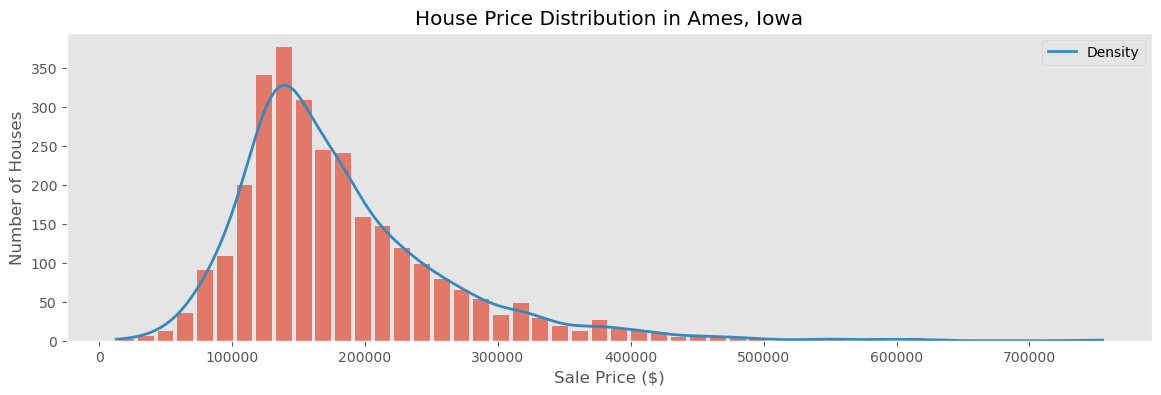

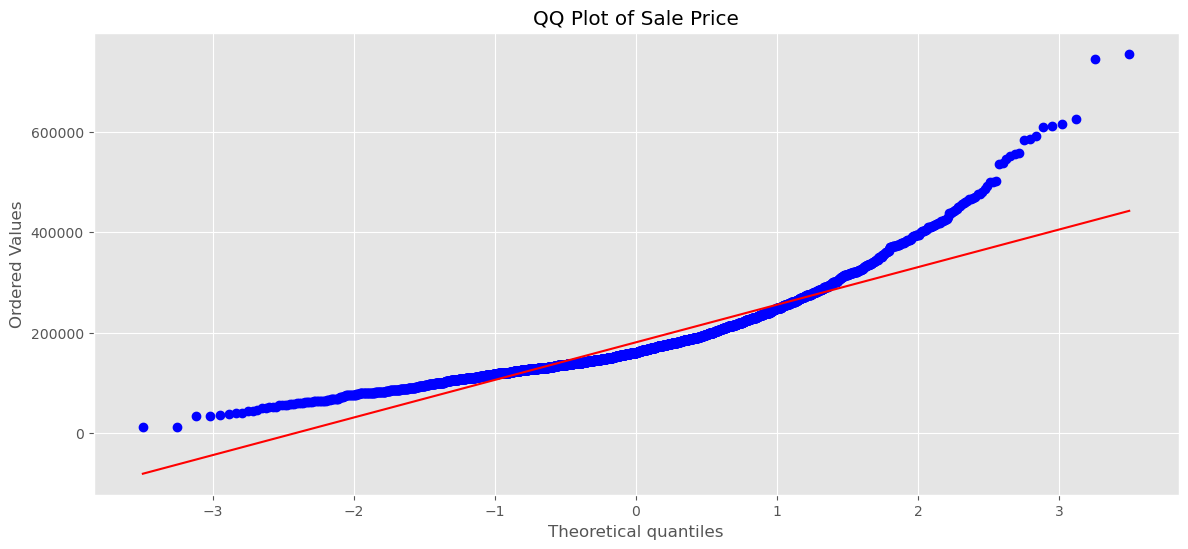

In [409]:
output_distribution_plotting(df, target_col='saleprice')

Comment: Overall, the distribution seems to be skewed and have fat-failed. Furthermore, there are some values that are extreme outliers, beyond 500,000 for example.

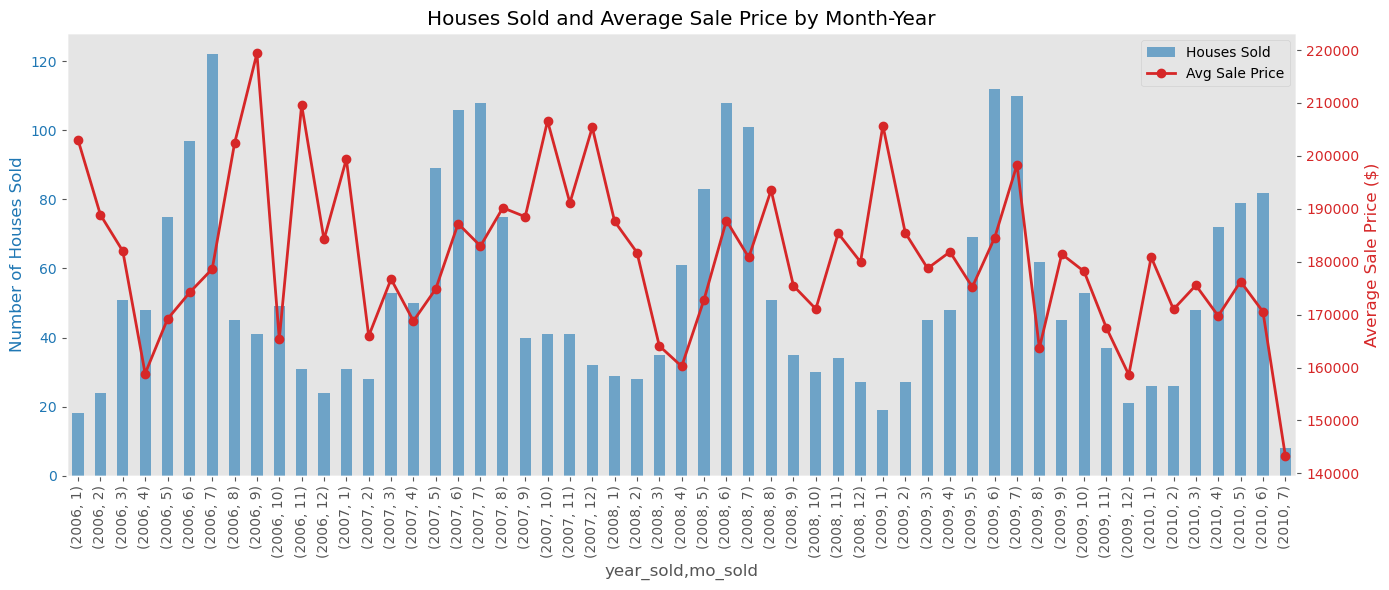

In [410]:
# Plot the number of houses sold and average sale price over time to analyze trends
# Shows both volume of sales and price changes month by month
plot_target_over_time(df, target_col='saleprice', year_col='year_sold', month_col='mo_sold')

Comment: Interesting to see some seasonal patterns. The number of houses sold is highest in the summer months and the average sale price tends to higher in the second half of the year. 


### Outliers

"There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately)." - Author of the dataset

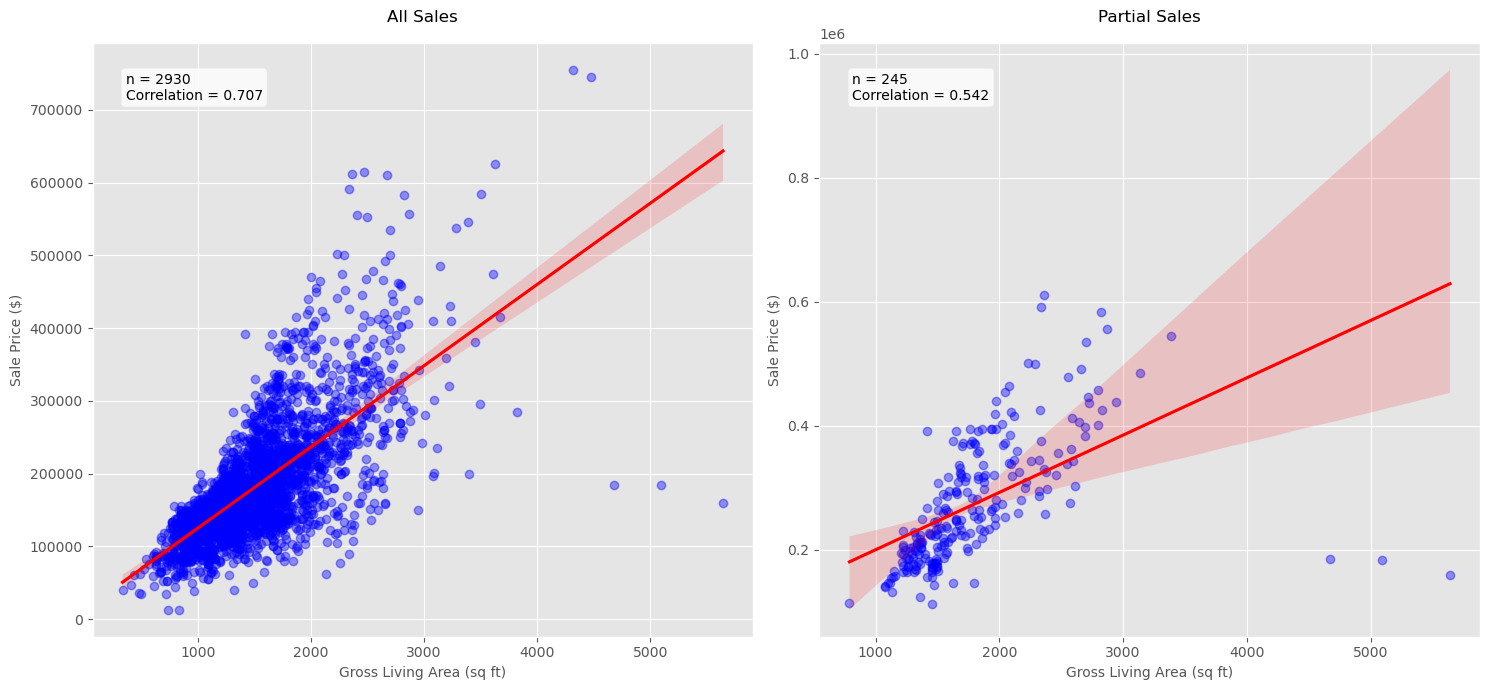

In [411]:
# Example usage:
plot_price_vs_sale_condition(df, sale_conditions=['Partial'])

Comment: We will drop the three observations that are true outliers where it does not represent actual market values. The two observations with higher prices can contain information about the market (special house features etc.) and we will keep them, while accounting for this in the models' loss function.

In [412]:
# Filter out the outliers where gr_liv_area > 4000 and saleprice < 200000
df = df[~((df.gr_liv_area > 4000) & (df.saleprice < 200000))]

#2. Feature Description

In [413]:
categorical_describer(df, nominal)


Categorical Columns Summary:
Total categorical columns: 27
Columns with missing values: 5


Total Missing  Percent Missing Data Type  \
misc_feature              2822         0.964127    object   
alley                     2729         0.932354    object   
mas_vnr_type              1775         0.606423    object   
garage_year_blt            159         0.054322   float64   
garage_type                157         0.053639    object   
exterior_2nd                 0         0.000000    object   
year_sold                    0         0.000000     int64   
year_remod/add               0         0.000000     int64   
year_blt                     0         0.000000     int64   
sale_condition               0         0.000000    object   
sale_type                    0         0.000000    object   
central_air                  0         0.000000    object   
heating                      0         0.000000    object   
foundation                   0         0.000000    object   
ms_subclass                  0         0.000000     int64   
ms_zoning                    0         0.000000    object   
roof_matl                    0         0.000000    object   
roof_style                   0         0.000000    object   
house_style                  0         0.000000    object   
bldg_type                    0         0.000000    object   
condition_2                  0         0.000000    object   
condition_1                  0         0.000000    object   
neighborhood                 0         0.000000    object   
lot_config                   0         0.000000    object   
land_contour                 0         0.000000    object   
street                       0         0.000000    object   
exterior_1st                 0         0.000000    object   

                                                 Value Information     Mode  \
misc_feature               4 unique values: Gar2, Othr, Shed, TenC     Shed   
alley                                  2 unique values: Grvl, Pave     Grvl   
mas_vnr_type       4 unique values: BrkCmn, BrkFace, CBlock, Stone  BrkFace   
garage_year_blt  103 unique values: 1895.0, 1896.0, 1900.0, 190...   2005.0   
garage_type      6 unique values: 2Types, Attchd, Basment, Buil...   Attchd   
exterior_2nd     17 unique values: AsbShng, AsphShn, Brk Cmn, B...  VinylSd   
year_sold            5 unique values: 2006, 2007, 2008, 2009, 2010     2007   
year_remod/add   61 unique values: 1950, 1951, 1952, 1953, 1954...     1950   
year_blt         118 unique values: 1872, 1875, 1879, 1880, 188...     2005   
sale_condition   6 unique values: Abnorml, AdjLand, Alloca, Fam...   Normal   
sale_type        10 unique values: COD, CWD, Con, ConLD, ConLI,...      WD    
central_air                                  2 unique values: N, Y        Y   
heating          6 unique values: Floor, GasA, GasW, Grav, OthW...     GasA   
foundation       6 unique values: BrkTil, CBlock, PConc, Slab, ...    PConc   
ms_subclass      16 unique values: 20, 30, 40, 45, 50, 60, 70, ...       20   
ms_zoning        7 unique values: A (agr), C (all), FV, I (all)...       RL   
roof_matl        7 unique values: CompShg, Membran, Metal, Roll...  CompShg   
roof_style       6 unique values: Flat, Gable, Gambrel, Hip, Ma...    Gable   
house_style      8 unique values: 1.5Fin, 1.5Unf, 1Story, 2.5Fi...   1Story   
bldg_type        5 unique values: 1Fam, 2fmCon, Duplex, Twnhs, ...     1Fam   
condition_2      8 unique values: Artery, Feedr, Norm, PosA, Po...     Norm   
condition_1      9 unique values: Artery, Feedr, Norm, PosA, Po...     Norm   
neighborhood     28 unique values: Blmngtn, Blueste, BrDale, Br...    NAmes   
lot_config       5 unique values: Corner, CulDSac, FR2, FR3, In...   Inside   
land_contour                   4 unique values: Bnk, HLS, Low, Lvl      Lvl   
street                                 2 unique values: Grvl, Pave     Pave   
exterior_1st     16 unique values: AsbShng, AsphShn, BrkComm, B...  VinylSd   

                 Mode Frequency  
misc_feature                 95  
alley                      

Comment: `ms_subclass` should be reformatted to be a categorical variable because it indicates building class. We will take notes of this for **preprocessing** 

In [414]:
categorical_describer(df, ordinal)


Categorical Columns Summary:
Total categorical columns: 23
Columns with missing values: 12


Total Missing  Percent Missing Data Type  \
pool_qu                  2915         0.995900    object   
fence                    2355         0.804578    object   
fireplace_qu             1422         0.485822    object   
garage_cond               159         0.054322    object   
garage_qu                 159         0.054322    object   
garage_finish             159         0.054322    object   
bsmt_exposure              83         0.028357    object   
bsmtfin_type_2             81         0.027673    object   
bsmt_cond                  80         0.027332    object   
bsmt_qu                    80         0.027332    object   
bsmtfin_type_1             80         0.027332    object   
electrical                  1         0.000342    object   
utilities                   0         0.000000    object   
heating_qu                  0         0.000000    object   
kitchen_qu                  0         0.000000    object   
functional                  0         0.000000    object   
exter_cond                  0         0.000000    object   
exter_qu                    0         0.000000    object   
overall_cond                0         0.000000     int64   
overall_qu                  0         0.000000     int64   
paved_drive                 0         0.000000    object   
land_slope                  0         0.000000    object   
lot_shape                   0         0.000000    object   

                                                Value Information    Mode  \
pool_qu                           4 unique values: Ex, Fa, Gd, TA      Ex   
fence                   4 unique values: GdPrv, GdWo, MnPrv, MnWw   MnPrv   
fireplace_qu                  5 unique values: Ex, Fa, Gd, Po, TA      Gd   
garage_cond                   5 unique values: Ex, Fa, Gd, Po, TA      TA   
garage_qu                     5 unique values: Ex, Fa, Gd, Po, TA      TA   
garage_finish                      3 unique values: Fin, RFn, Unf     Unf   
bsmt_exposure                     4 unique values: Av, Gd, Mn, No      No   
bsmtfin_type_2      6 unique values: ALQ, BLQ, GLQ, LwQ, Rec, Unf     Unf   
bsmt_cond                     5 unique values: Ex, Fa, Gd, Po, TA      TA   
bsmt_qu                       5 unique values: Ex, Fa, Gd, Po, TA      TA   
bsmtfin_type_1      6 unique values: ALQ, BLQ, GLQ, LwQ, Rec, Unf     GLQ   
electrical       5 unique values: FuseA, FuseF, FuseP, Mix, SBrkr   SBrkr   
utilities                 3 unique values: AllPub, NoSeWa, NoSewr  AllPub   
heating_qu                    5 unique values: Ex, Fa, Gd, Po, TA      Ex   
kitchen_qu                    5 unique values: Ex, Fa, Gd, Po, TA      TA   
functional      8 unique values: Maj1, Maj2, Min1, Min2, Mod, ...     Typ   
exter_cond                    5 unique values: Ex, Fa, Gd, Po, TA      TA   
exter_qu                          4 unique values: Ex, Fa, Gd, TA      TA   
overall_cond           9 unique values: 1, 2, 3, 4, 5, 6, 7, 8, 9       5   
overall_qu        10 unique values: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10       5   
paved_drive                              3 unique values: N, P, Y       Y   
land_slope                         3 unique values: Gtl, Mod, Sev     Gtl   
lot_shape                     4 unique values: IR1, IR2, IR3, Reg     Reg   

                Mode Frequency  
pool_qu                      4  
fence                      330  
fireplace_qu               741  
garage_cond               2662  
garage_qu                 2612  
garage_finish             1231  
bsmt_exposure             1906  
bsmtfin_type_2            2496  
bsmt_cond                 2613  
bsmt_qu                   1283  
bsmtfin_type_1             856  
electrical                2679  
utilities                 2924  
heating_qu                1492  
kitchen_qu                1494  
functional                2725  
exter_cond                2546  
exter_qu                  1799  
overall_cond              1651  
overall_qu                 825  
paved_drive               2649  


The scale for quality and condition is: Ex - Excellent, Gd - Good, TA - Average/Typical, Fa - Fair, Po - Poor. Ordinal encoding can apply to this scale for `pool_qu`, `fireplace_qu`, `garage_cond`, `garage_qu`, `bsmt_cond`, `bsmt_qu`, `heating_qu`, `kitchen_qu`, `exter_cond`, `exter_qu`. Significant missing values exist for `pool`, `fireplace`, and `fence` quality. 

In [415]:
numerical_describer(df, continuous)


Numerical Columns Summary:
Total numerical columns: 19
Columns with missing values: 7


Total Missing  Percent Missing Data Type  \
lot_frontage              490         0.167407   float64   
mas_vnr_area               23         0.007858   float64   
bsmtfin_sf_1                1         0.000342   float64   
bsmtfin_sf_2                1         0.000342   float64   
bsmt_unf_sf                 1         0.000342   float64   
total_bsmt_sf               1         0.000342   float64   
garage_area                 1         0.000342   float64   
open_porch_sf               0         0.000000     int64   
pool_area                   0         0.000000     int64   
screen_porch                0         0.000000     int64   
3ssn_porch                  0         0.000000     int64   
enclosed_porch              0         0.000000     int64   
low_qu_fin_sf               0         0.000000     int64   
wood_deck_sf                0         0.000000     int64   
gr_liv_area                 0         0.000000     int64   
lot_area                    0         0.000000     int64   
2nd_flr_sf                  0         0.000000     int64   
1st_flr_sf                  0         0.000000     int64   
misc_val                    0         0.000000     int64   

                                         Value Information          Mean  \
lot_frontage      Range: 21.0 to 313.0 (129 unique values)     69.075503   
mas_vnr_area      Range: 0.0 to 1600.0 (444 unique values)    101.044077   
bsmtfin_sf_1      Range: 0.0 to 2288.0 (993 unique values)    439.011620   
bsmtfin_sf_2      Range: 0.0 to 1526.0 (275 unique values)     49.773411   
bsmt_unf_sf      Range: 0.0 to 2336.0 (1138 unique values)    559.005810   
total_bsmt_sf    Range: 0.0 to 3206.0 (1056 unique values)   1047.790841   
garage_area       Range: 0.0 to 1488.0 (602 unique values)    472.123377   
open_porch_sf          Range: 0 to 742 (249 unique values)     47.178340   
pool_area               Range: 0 to 800 (13 unique values)      2.081654   
screen_porch           Range: 0 to 576 (121 unique values)     16.018449   
3ssn_porch              Range: 0 to 508 (31 unique values)      2.595149   
enclosed_porch        Range: 0 to 1012 (183 unique values)     23.035190   
low_qu_fin_sf          Range: 0 to 1064 (36 unique values)      4.681585   
wood_deck_sf          Range: 0 to 1424 (379 unique values)     93.517253   
gr_liv_area        Range: 334 to 4476 (1289 unique values)   1495.961736   
lot_area        Range: 1300 to 215245 (1957 unique values)  10109.374786   
2nd_flr_sf            Range: 0 to 2065 (633 unique values)    334.949778   
1st_flr_sf         Range: 334 to 3820 (1080 unique values)   1156.330372   
misc_val              Range: 0 to 15500 (37 unique values)     44.879057   

                    Std Dev     Min     25%     50%      75%       Max  
lot_frontage      22.787266    21.0    58.0    68.0     80.0     313.0  
mas_vnr_area     177.098747     0.0     0.0     0.0    164.0    1600.0  
bsmtfin_sf_1     439.355775     0.0     0.0   370.0    734.0    2288.0  
bsmtfin_sf_2     169.247708     0.0     0.0     0.0      0.0    1526.0  
bsmt_unf_sf      439.569050     0.0   219.0   464.5    801.0    2336.0  
total_bsmt_sf    422.493494     0.0   793.0   990.0   1300.0    3206.0  
garage_area      213.939485     0.0   320.0   480.0    576.0    1488.0  
open_porch_sf     66.551515     0.0     0.0    27.0     70.0     742.0  
pool_area         34.502476     0.0     0.0     0.0      0.0     800.0  
screen_porch      56.113774     0.0     0.0     0.0      0.0     576.0  
3ssn_porch        25.154079     0.0     0.0     0.0      0.0     508.0  
enclosed_porch    64.167697     0.0     0.0     0.0      0.0    1012.0  
low_qu_fin_sf     46.334003     0.0     0.0     0.0      0.0    1064.0  
wood_deck_sf     126.112082     0.0     0.0     0.0    168.0    1424.0  
gr_liv_area      491.993241   334.0  1126.0  1442.0   1741.0    4476.0  
lot_area        7782.875751  1300.0  7439.0  9430.0  11523.0  215245.0  
2nd_flr_sf       427.842304     0.0     0.0     0.0  

Comment: Some features indicate a lot of large variations like `misc_val`, i.e. value of miscellaneous feature which makes sense give that it indicates quite a diverse range of thing: `Elev`: Elevator,`Gar2`: 2nd Garage (if not described in garage section), `Othr`: Other, `Shed`: Shed (over 100 SF), `TenC`: Tennis Court. When fitting a GLM, we can use a onehot encoder maybe

In [416]:
numerical_describer(df, discrete)


Numerical Columns Summary:
Total numerical columns: 10
Columns with missing values: 3


Total Missing  Percent Missing Data Type  \
bsmt_full_bath              2         0.000683   float64   
bsmt_half_bath              2         0.000683   float64   
garage_cars                 1         0.000342   float64   
full_bath                   0         0.000000     int64   
half_bath                   0         0.000000     int64   
bedroom_abvgr               0         0.000000     int64   
kitchen_abvgr               0         0.000000     int64   
totrms_abvgr                0         0.000000     int64   
fireplaces                  0         0.000000     int64   
mo_sold                     0         0.000000     int64   

                                  Value Information      Mean   Std Dev  Min  \
bsmt_full_bath  Range: 0.0 to 3.0 (5 unique values)  0.430427  0.524076  0.0   
bsmt_half_bath  Range: 0.0 to 2.0 (4 unique values)  0.060855  0.244759  0.0   
garage_cars     Range: 0.0 to 5.0 (7 unique values)  1.765892  0.760260  0.0   
full_bath           Range: 0 to 4 (5 unique values)  1.565767  0.552472  0.0   
half_bath           Range: 0 to 2 (3 unique values)  0.378886  0.502494  0.0   
bedroom_abvgr       Range: 0 to 8 (8 unique values)  2.854458  0.827996  0.0   
kitchen_abvgr       Range: 0 to 3 (4 unique values)  1.044414  0.214181  0.0   
totrms_abvgr      Range: 2 to 14 (13 unique values)  6.436625  1.560140  2.0   
fireplaces          Range: 0 to 4 (5 unique values)  0.597882  0.646169  0.0   
mo_sold           Range: 1 to 12 (12 unique values)  6.215237  2.712368  1.0   

                25%  50%  75%   Max  
bsmt_full_bath  0.0  0.0  1.0   3.0  
bsmt_half_bath  0.0  0.0  0.0   2.0  
garage_cars     1.0  2.0  2.0   5.0  
full_bath       1.0  2.0  2.0   4.0  
half_bath       0.0  0.0  1.0   2.0  
bedroom_abvgr   2.0  3.0  3.0   8.0  
kitchen_abvgr   1.0  1.0  1.0   3.0  
totrms_abvgr    5.0  6.0  7.0  14.0  
fireplaces      0.0  1.0  1.0   4.0  
mo_sold         4.0  6.0  8.0  12.0

#3. Missing values and direct insights from dictionary

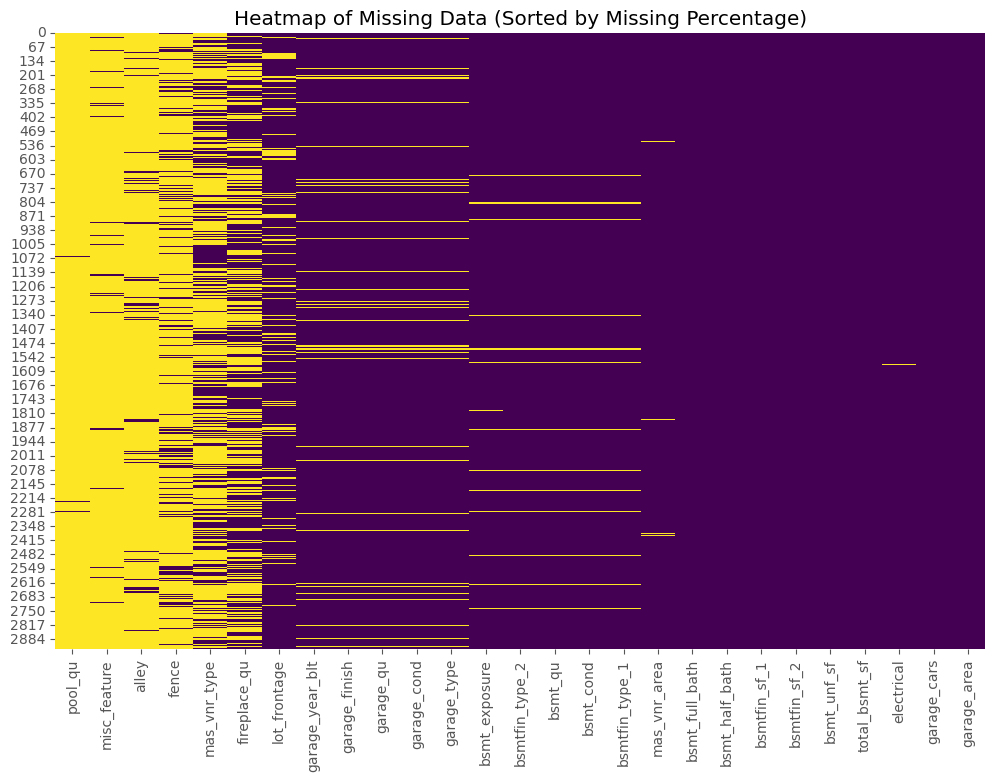

In [417]:
# Call the function to plot the heatmap
plot_missing_data_heatmap(df)

## Pool, Basement, Fireplace, Fence, Alley, Misc Features

Firstly, from the data dictionary, we know that 'NA' would imply No Pools! In fact, we can check this with the pool area.  

In [418]:
# Assert whether all pool_area values are 0 for missing pool_qu
assert (df[df['pool_qu'].isnull()]['pool_area'] == 0).all(), "Not all missing pool_qu have pool_area equal to 0"

In the dataset, missing values for variables such as `bsmt` (basement-related features) are represented by `NA`, indicating the absence of a basement. Similarly, `NA` values in variables like `fence`,`fireplace`, `alley` denote the absence of these respective features (e.g., no fence, no garage, no fireplace, and no alley access). Additionally, `NA` in the `misc_feature` variable signifies that no miscellaneous features are recorded for those entries. Then, the numerical features of corresponding areas are also missing and we will fill them in with 0. 

In [419]:
df = simple_fill_missing_by_keywords(df, ['pool', 'bsmt', 'fence', 'fireplace', 'alley', 'misc_feature'])

### Electrical

There is only one missing value for electrical. 

In [420]:
df[df['electrical'].isnull()][['ms_subclass', 'neighborhood', 'year_blt', 'street']]

ms_subclass neighborhood  year_blt street
1577           80       Timber      2006   Pave

In [421]:
# Check for the type similar properties in the area as they tend to have the same electrical type
df[(df['ms_subclass'] == '80') & (df['neighborhood'] == "Timber")].groupby(['street', 'year_blt'])['electrical'].value_counts().unstack(fill_value=0)

Empty DataFrame
Columns: []
Index: []

All the buildings in the paved road access and `ms_subclass` (building class) and this Timber neighborhood all have SBrkr (Standard Circuit Breakers & Romex) as the electrical type. Therefore, it is reasonable to impute this missing value with SBrkr. 

In [422]:
# Fill missing electrical value with SBrkr based on similar properties in the area
df['electrical'] = df['electrical'].fillna('SBrkr')

### Garage

The column `garage_type` denotes 'No Garage' rather than 'NA' as when there is no garage but there are also NAs, and also the dictionary indicates that 'NA' for `garage_year_blt` can indicate missing garages. Here, we take a closer look at the garage type and area. 

In [423]:
consistency_missing_type_area(df, 'garage_area', 'garage_type')

{'percent_missing_area_zero': 100.0,
 'percent_missing_area_missing': 0.0,
 'percent_missing_area_other': 0.0}

In fact all the missing garage_type also have area zero so it means no garage. 

In [424]:
# Get missing garage info
garage_cols = df.columns[df.columns.str.contains('garage')]
missing_mask = df['garage_year_blt'].isnull()
missing = df.loc[missing_mask, garage_cols]
# Only either detached or no garage types for columns with missing year built. 
missing['garage_type'].value_counts(dropna=False), missing[missing['garage_type']=='Detchd'].head(2)

(garage_type
 NaN       157
 Detchd      2
 Name: count, dtype: int64,
      garage_type  garage_year_blt garage_finish  garage_cars  garage_area  \
 1356      Detchd              NaN           NaN          1.0        360.0   
 2236      Detchd              NaN           NaN          NaN          NaN   
 
      garage_qu garage_cond  
 1356       NaN         NaN  
 2236       NaN         NaN  )

In [425]:
# Only one observation where area is missing also.
df[df['garage_area'].isnull()][garage_cols]

garage_type  garage_year_blt garage_finish  garage_cars  garage_area  \
2236      Detchd              NaN           NaN          NaN          NaN   

     garage_qu garage_cond  
2236       NaN         NaN

Although the majority of missing values for areas and year built indeed stem from garage type being recorded as 'No Garage' to begin with. As we denote the lack of a facility as `NA` (non-applicable) in such cases, we may want to standarise this notations. 

This indicates some inconsistencies in the data recording. Although the garage type is Detached, no built years are recorded. One observation clearly has a garage area, while the later lacks everthing. In this case, we may fill in the `garage_year_blt` with the year built of the property. For where garage_area is missing, we will fill in with 0. For all the other finish, condition and quality columns, we may just keep 'NA' category (noting that this denotes either missing or not applicable), given that the non-easily-fillable missing values are too small to introduce another category

Now, check for inconsistencies in the year built and year sold if any houses are sold before they are built or fully remodelled. Furthermore, we check if any values are out of the range of the dataset 2006-2010. 

In [426]:
report_inconsistent_years(df, ['year_blt','year_remod/add' ,'garage_year_blt'], 'year_sold')

year_blt  year_remod/add  garage_year_blt  year_sold
1702      2007            2008           2007.0       2007
2260      2006            2007           2207.0       2007

There is one observation that is built and one that is remodeled after it is sold. Additionally, there seems to be a typo for index 2260 in its `garage_year_blt`. However, it seems like the garage was build with remodelled and it was a typo from 2007 to 2207. We will fix this, while it is possible that a property is sold before it is built, we will not remove any observations. 

In [427]:
# Apply the imputer
df = garage_imputer(df)

### Masonry veneer type and area

In [428]:
# Call the function and print the results for 'mas_vnr_area' and 'mas_vnr_type'
consistency_missing_type_area(df, 'mas_vnr_area', 'mas_vnr_type')

{'percent_missing_area_zero': 98.30985915492958,
 'percent_missing_area_missing': 1.295774647887324,
 'percent_missing_area_other': 0.39436619718309857}

In [429]:
# Check for inconsistencies in masonry veneer data
print("\nBreakdown of mas_vnr_area values where mas_vnr_type is missing:")
df[df['mas_vnr_type'].isnull()]['mas_vnr_area'].value_counts().sort_index()


Breakdown of mas_vnr_area values where mas_vnr_type is missing:


mas_vnr_area
0.0      1745
1.0         3
285.0       1
288.0       1
312.0       1
344.0       1
Name: count, dtype: int64

In [430]:
# Show rows where mas_vnr_area is missing
df[df['mas_vnr_area'].isnull()][['mas_vnr_area', 'mas_vnr_type']]

mas_vnr_area mas_vnr_type
55             NaN          NaN
484            NaN          NaN
517            NaN          NaN
538            NaN          NaN
867            NaN          NaN
1095           NaN          NaN
1119           NaN          NaN
1122           NaN          NaN
1127           NaN          NaN
1184           NaN          NaN
1454           NaN          NaN
1727           NaN          NaN
1751           NaN          NaN
1783           NaN          NaN
1799           NaN          NaN
1839           NaN          NaN
1840           NaN          NaN
2229           NaN          NaN
2260           NaN          NaN
2382           NaN          NaN
2392           NaN          NaN
2455           NaN          NaN
2823           NaN          NaN

Interestingly, for most where `mas_vnr_type` is missing, we observe that its area is 0. 1.2% of missing types has missing areas and  there is very small proportion where the area takes some other values. And for all where mas_vnr_area are missing, types are also missing. We will then impute all the missing `mas_vnr_type` with 'NA' and `mas_vnr_area` with 0. This can be done by simply adding 'mas_vnr' to the keywords when calling ``simple_fill_missing_by_keywords()``

In [431]:
df = simple_fill_missing_by_keywords(df, ['mas_vnr'])

### Lot Frontage

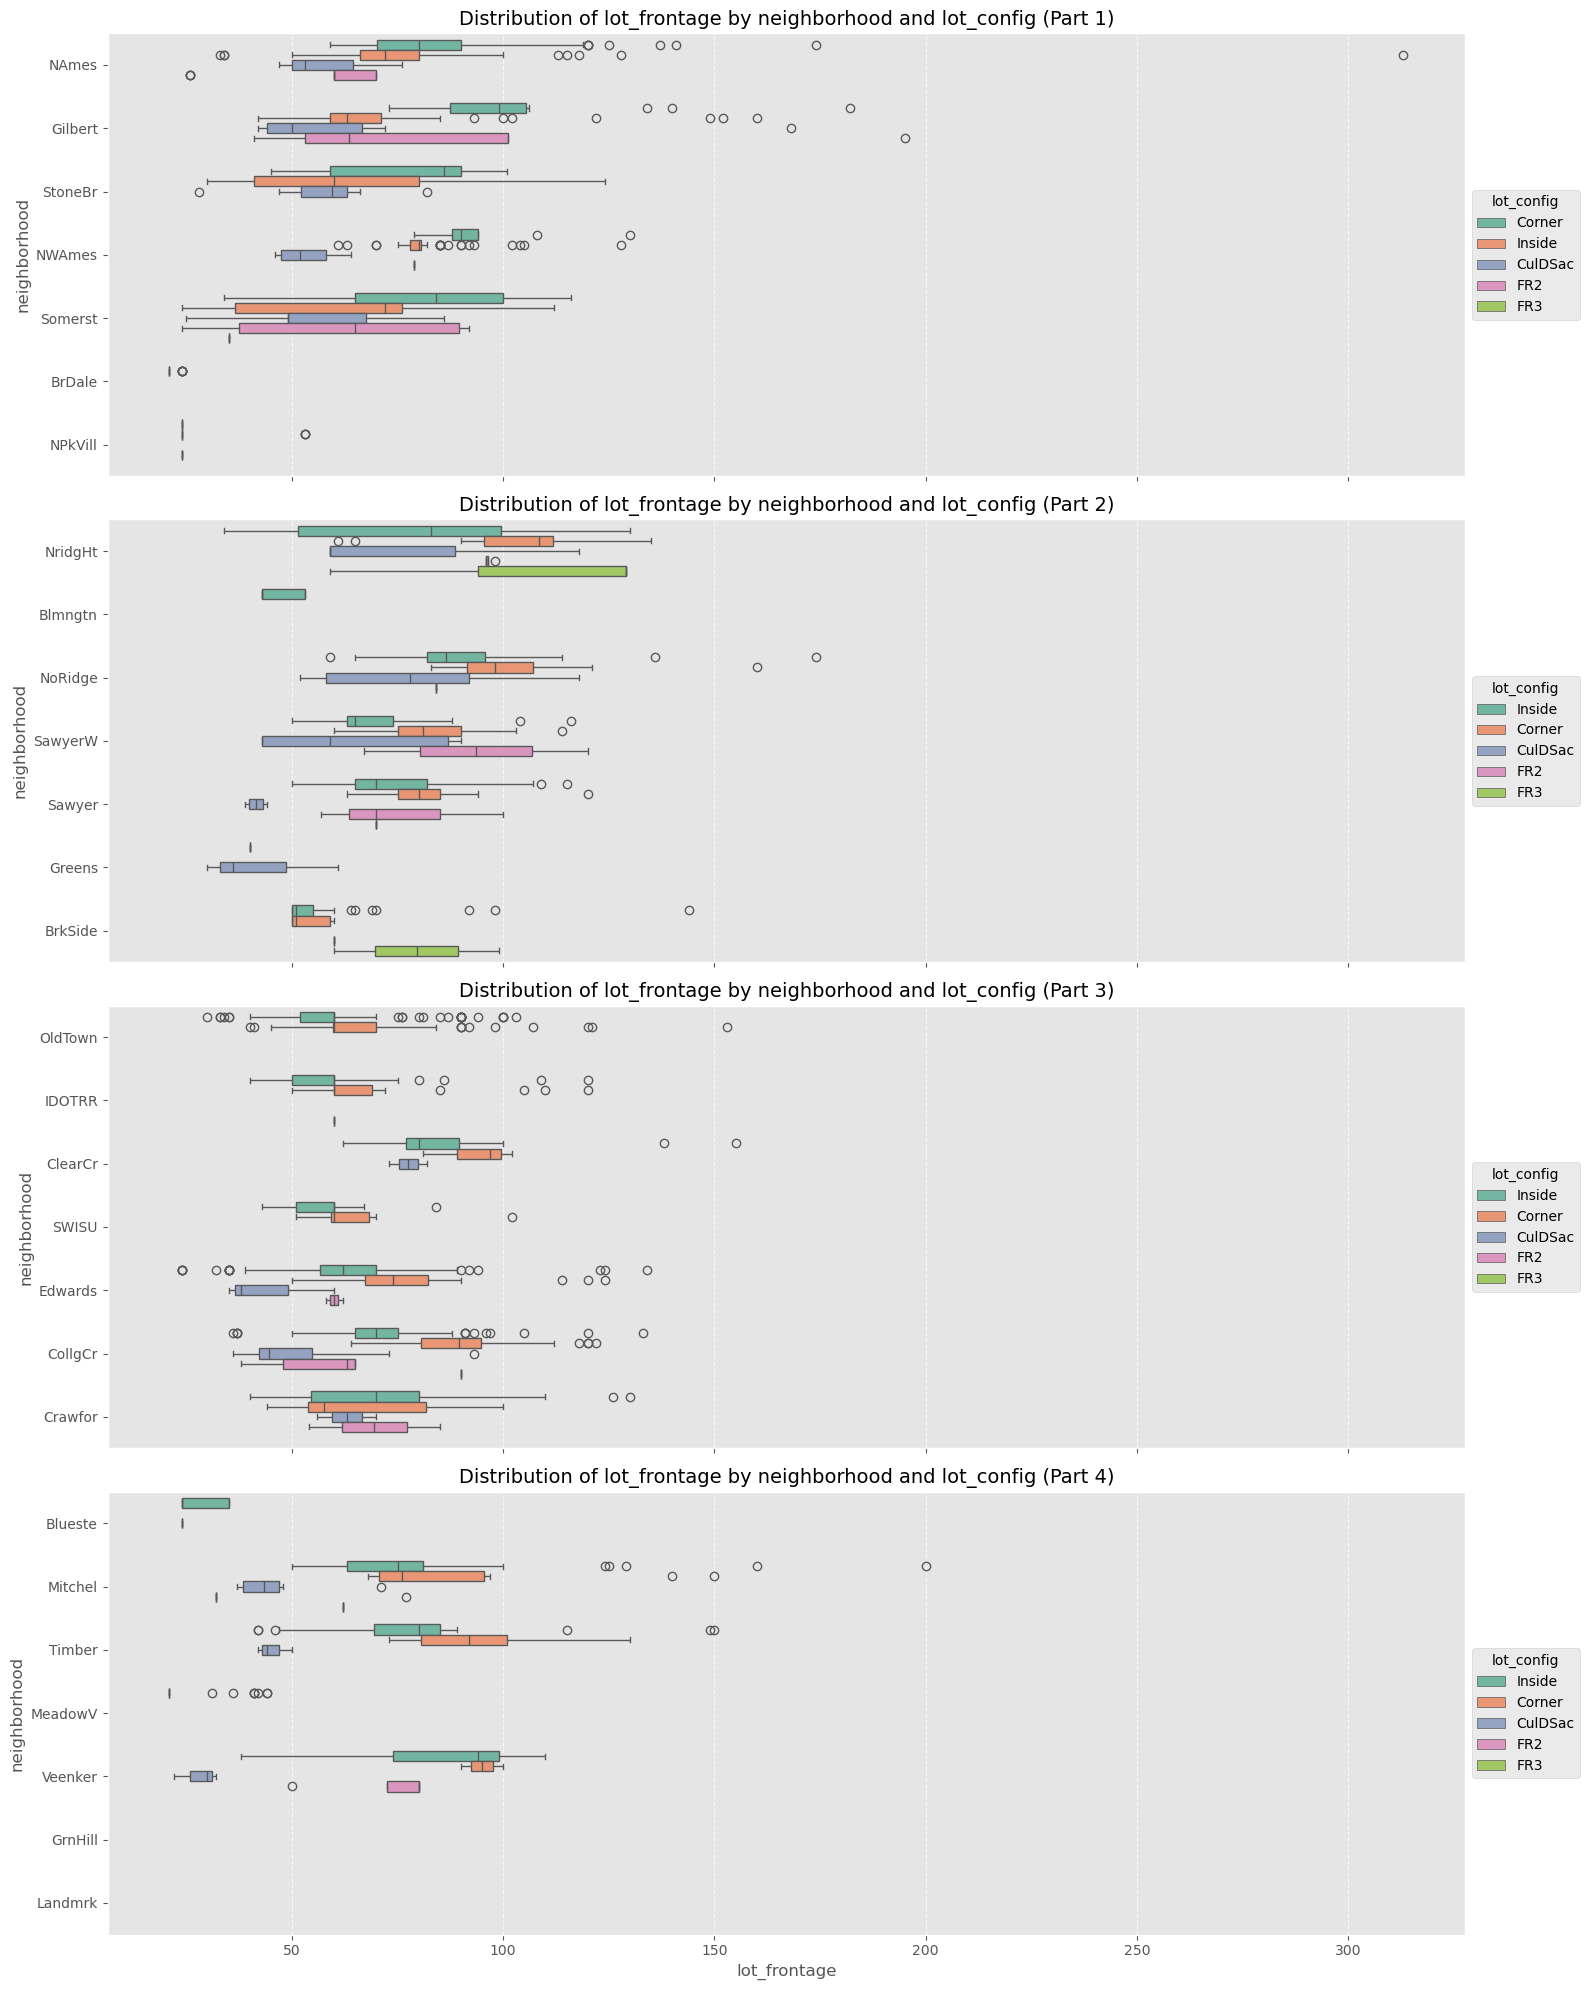

In [432]:
# Example usage
box_plot_dist(df, x='lot_frontage', y='neighborhood', hue='lot_config')

This shows that although there are some outliers, distribution of `lot_frontage` is very concentrated conditioned on `lot_config` (the configuration of the lot) and `neighborhood` that the discrepancy are within 100 feet. We will then impute the missing values with the median of the `lot_frontage` of observations with the same `neighborhood` and `lot_config`. This imputer will better incorporated into the pipeline to avoid data leakage (i.e. only imputing for each train/test set separately).

Before proceeding to the next step, we will format the data types for consistency.

In [433]:
df = type_formatting(
    df,
    discrete_cols=discrete,
    continuous_cols=continuous,
    nominal_cols=nominal,
    ordinal_cols=ordinal,
    ordinal_mappings=load_config().get("ordinal_mappings", [])
)

#4. Feature Distribution

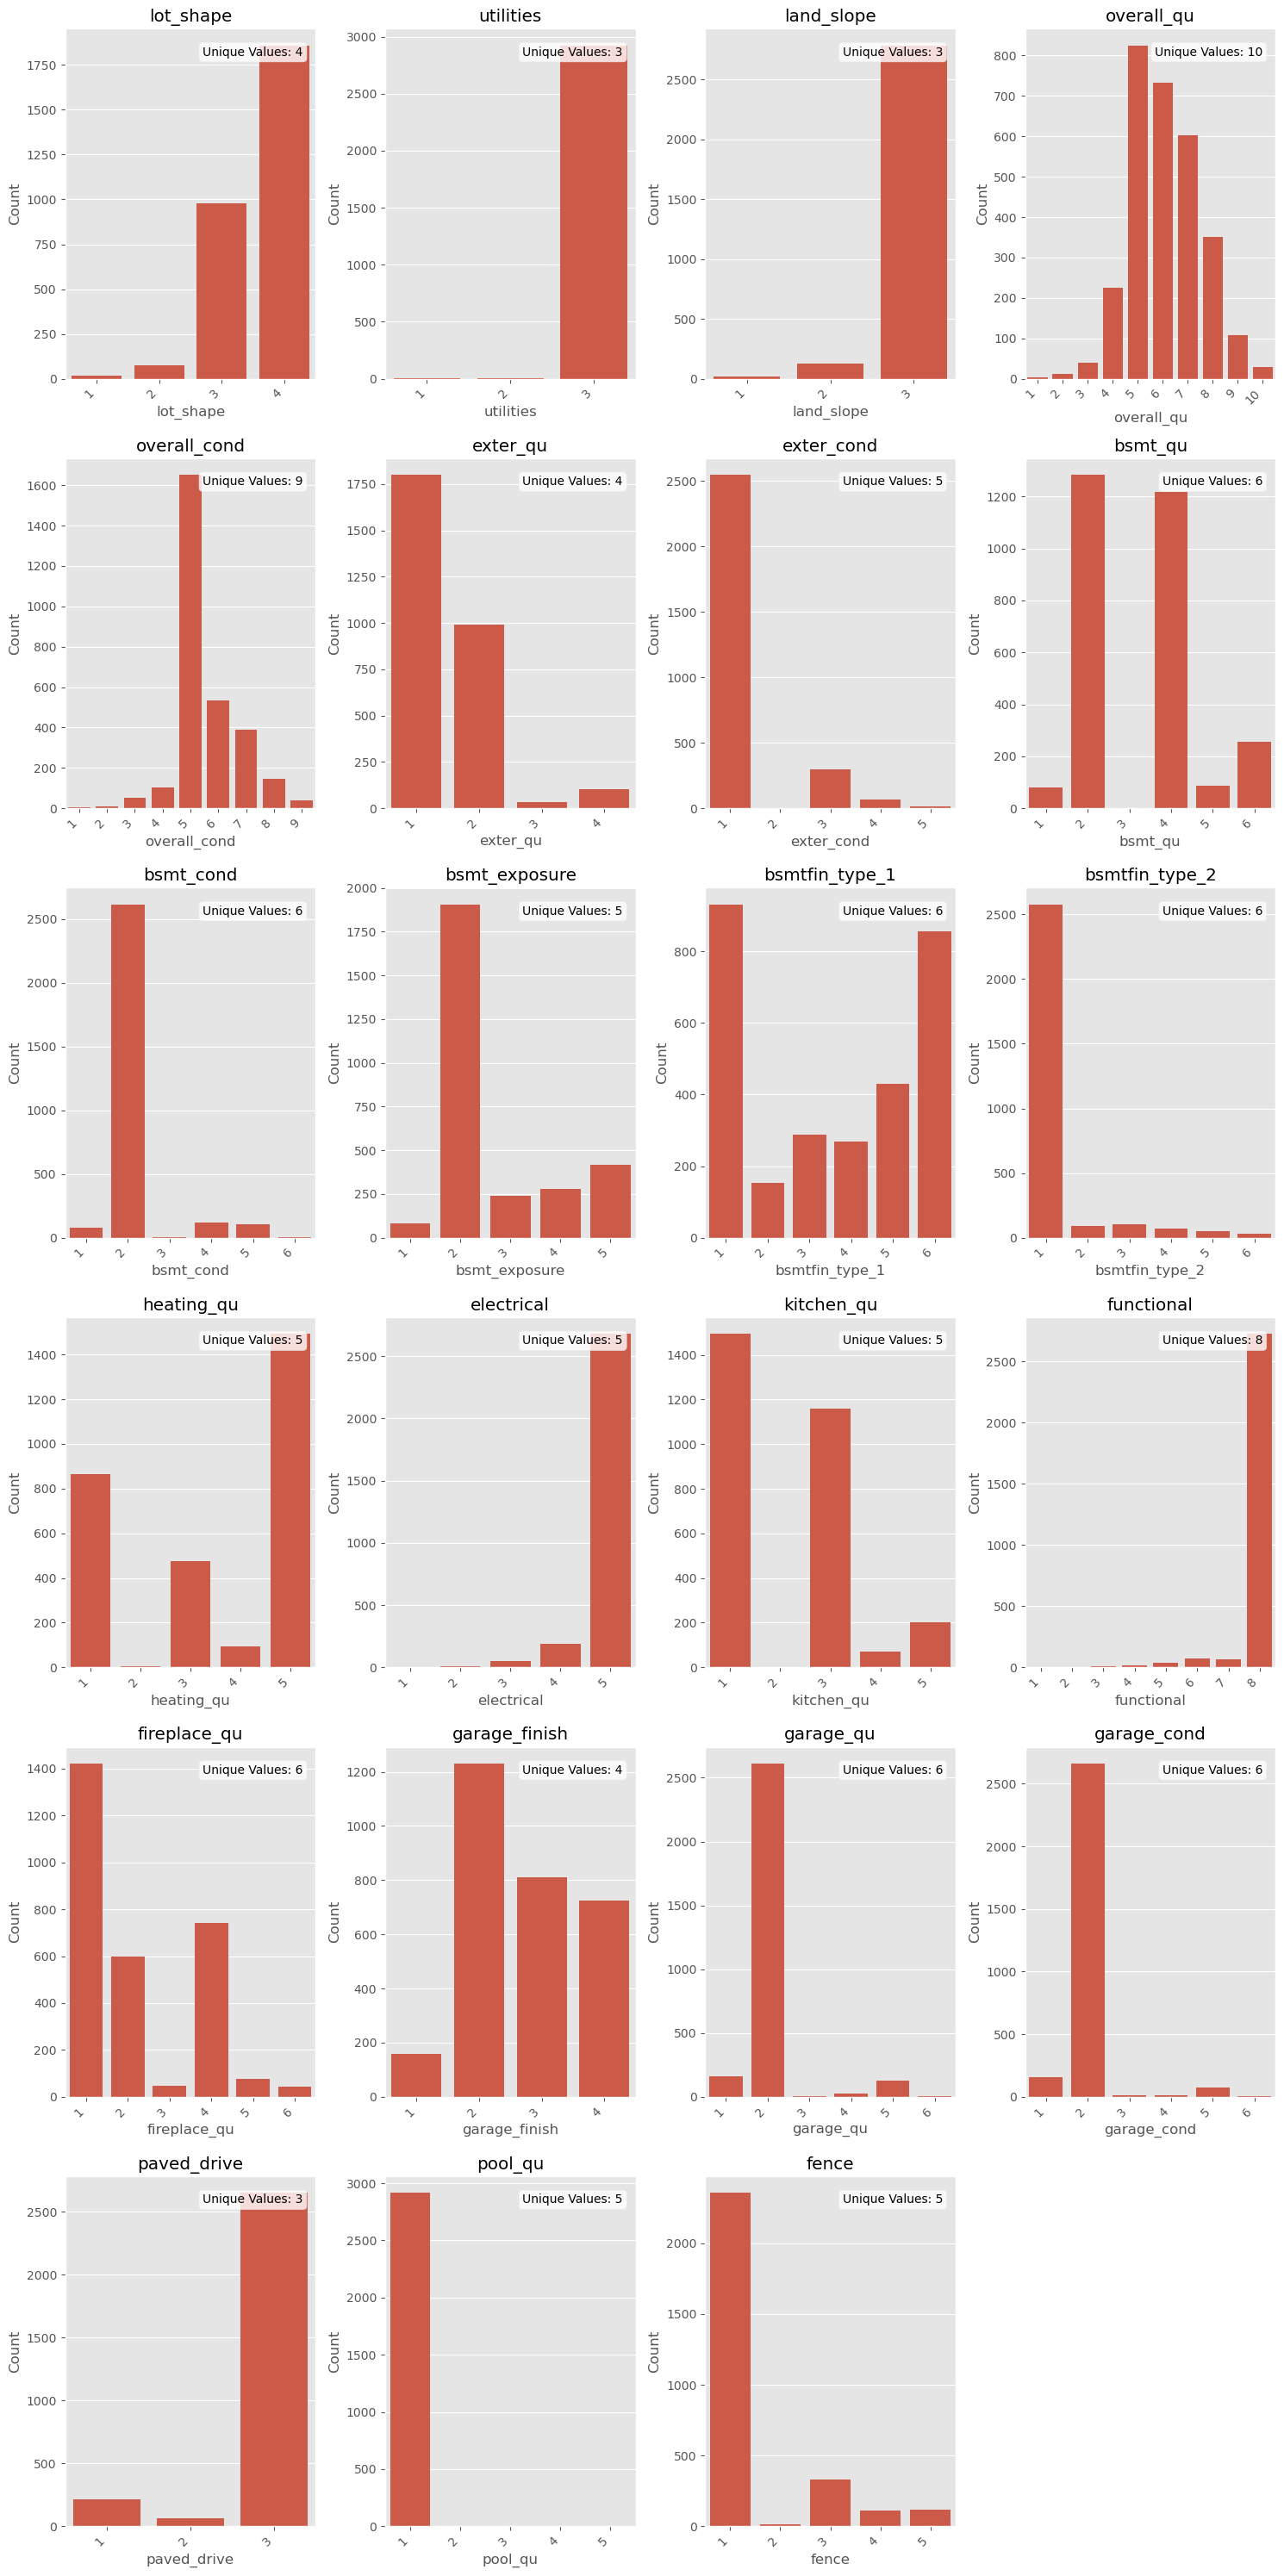

Exiting the interactive plotting.


In [471]:
plot_feature_distributions_interactive(df, nominal, ordinal, continuous, discrete)

Feel free to select what you want to see. Give it 2-3 secs.

1. Most categorical features exhibit strong class imbalance, with one or two dominant categories.

2. For continuous features, measurements related to property size (`lot_frontage`, `lot_area`) and living spaces (room areas, garage areas) show right-skewed distributions with heavy tails. Other continuous variables tend to have a high concentration of zeros with extended right tails.

3. For discrete features, we observe several notable patterns:
   a. The distributions of `garage_year_blt` and `year_blt` are remarkably similar, even though we only imputed the built year for garage for 153 observations only. 
   
   b. The distributions of full and half bathrooms show strong correlation. Maybe we can also consider the percentage of half bath and full bath as to the distribution of the total number of baths in the house. This can provide information about the building's capacity for full/half baths rather than just the number of different types. For example, a house with 2 full baths and 2 half baths (50% full, 50% half) is quite different in utility from one with 3 full baths and 1 half bath (75% full, 25% half).

   c. Given the narrow time window of sales (2006-2010), calculating building age at sale may not add significant value as that does not differ significantly from the information on year built. However, we can add a feature of the year difference between built and remodelled relative to the year built and sold. This will clearly be scaled between 0 and 1; with 0 indicating the building never gets remodelled and 1 indicating the building is remodelled very recently. Hence, this can show the relative timing of the remodelling relative to the life-span of the building till it gets sold. 

   d. Apart from features related to years, all other features maybe considered as ordinal categories, all maybe have a monotonic relationship with the sale price that the more rooms and facilities, the better.

4. Pool information is very sparse. Hence, we can consider transform it into just one variable, have a good enough pool (scored above 3), bad pool or no pool; instead of keeping two variables on pool quality and pool area. Actually we can use some monotonic binning custom transformer for these ordinal categorical variables where the values are too sparse. 

Let's take a closer look at the sparsity of the categorical features. 

In [435]:
# Analyze categorical features
cat_analysis = analyze_categorical_sparsity(df, threshold_dominant=0.95, threshold_rare=0.01)
cat_analysis

Feature  Unique Values Most Common  Most Common % Least Common  \
0       condition_2              8        Norm      99.009224         RRAn   
1         roof_matl              7     CompShg      98.565084        Metal   
2           heating              6        GasA      98.462590        Floor   
3      misc_feature              5          NA      96.412709         TenC   
4            street              2        Pave      99.590024         Grvl   
5          year_blt            118        2005       4.851384         1913   
6   garage_year_blt            110      2005.0       4.953878       1943.0   
7    year_remod/add             61        1950      12.333447         1982   
8      neighborhood             28       NAmes      15.134950      Landmrk   
9      exterior_2nd             17     VinylSd      34.677144        Other   
10        sale_type             10         WD       86.641613          VWD   
11     exterior_1st             16     VinylSd      35.052955      ImStucc   
12      ms_subclass             16          20      36.829518          150   
13        ms_zoning              7          RL      77.553809      A (agr)   
14      condition_1              9        Norm      86.129142         RRNe   
15       roof_style              6       Gable      79.296208         Shed   
16      house_style              8      1Story      50.563717       2.5Fin   
17     mas_vnr_type              5          NA      60.642296       CBlock   
18       foundation              6       PConc      44.653229         Wood   
19      garage_type              7      Attchd      59.070721      CarPort   
20   sale_condition              6      Normal      82.439358      AdjLand   
21       lot_config              5      Inside      73.044072          FR3   
22            alley              3          NA      93.235395         Pave   
23     land_contour              4         Lvl      89.955586          Low   
24        bldg_type              5        1Fam      82.746840       2fmCon   
25      central_air              2           Y      93.303724            N   
26        year_sold              5        2007      23.641954         2010   

    Least Common %  Has Dominant  Rare Categories  
0         0.034165          True                7  
1         0.034165          True                6  
2         0.034165          True                5  
3         0.034165          True                3  
4         0.409976          True                1  
5         0.034165         False               76  
6         0.034165         False               66  
7         0.307482         False               28  
8         0.034165         False                7  
9         0.034165         False                7  
10        0.034165         False                7  
11        0.034165         False                6  
12        0.034165         False                5  
13        0.068329         False                4  
14        0.204988         False                4  
15        0.170823         False                4  
16        0.273317         False                3  
17        0.034165         False                2  
18        0.170823         False                2  
19        0.512470         False                2  
20        0.409976         False                2  
21        0.478305         False                1  
22        2.664845         False                0  
23        2.049880         False                0  
24        2.118210         False                0  
25        6.696276         False                0  
26       11.650154         False                0

Comment: This gives us a good overview of the sparsity of the categorical features. We may then consider adding infrequent categories for features where there are many possible values, existing a dominant feature and multiple categories falls short of the threshold of total observations (here we picked 1%): `condition_2`, `roof_matl`, `heating` (potentially only gas or non-gas).

#5. Features' Correlation with Target

Feel free to select what you want to see. Give it 2-3 secs.

In [436]:
plot_feature_target_relationships_interactive(df, nominal, ordinal, continuous, discrete, target_col='saleprice')

Exiting the interactive plotting.


For discrete features, we can see that the patterns of `year_blt` and `year_remod/add` affecting the sale price in very similar way. Given that we have argued about the value of years built, we may consider using a dummy of the property ever been remodeled or not. 

For the baths, the interesting negative association of the number of half baths in the basement with house price, indicates that there may be a constrained on the number of baths that can be put in the basement. So, we can add additional features on the percentage of full baths in total and in the basement separately that can give information about the allocation of the baths rather than just the number of different types.

For continuous features, total basement area `total_bsmt_sf` and `1st_flr_sf` have very similar relationship with the sale price. We may simply consider `total_bsmt_1st_flr_sf` as a single feature as opposed to that of the second floor because it essentially captures the non-above ground living area. 

For ordinal variable, it is not surprising that the overall quality  goes very well with the sale price. Indicators of facilities' qualities and conditions also goes as we expect for the monotonicity effect (higher quality, higher price). However, for `garage`, there are usually a switch among the top ones for rankings and seems like as long as it is a good enough garage, then it's fine for the buyer. 

For the nominal features, it is not surprising that the neighborhood and the type of the house (mszoning) has a strong effect on the sale price. The first and second exterior covering on house also seems to have similar effect on house price, indicating the importance of the materials itself.

# 6. Closer look at categorical features

**ANOVA (Analysis of Variance)** is a statistical method used to assess the influence of categorical features on a continuous target variable by comparing the means of different groups.
1. Perform one-way ANOVA on each categorical feature to determine its effect on the target variable. This involves calculating the F-statistic, which is the ratio of the variance between group means to the variance within the groups.
2. Calculate the effect size (eta squared, η²) for each feature to quantify its impact. The formula for eta squared is η² = SS_between / SS_total, where SS_between is the sum of squares between groups and SS_total is the total sum of squares.
3. Identify and rank the top categorical features with the largest effect sizes for further analysis, focusing on those with the highest η² values.


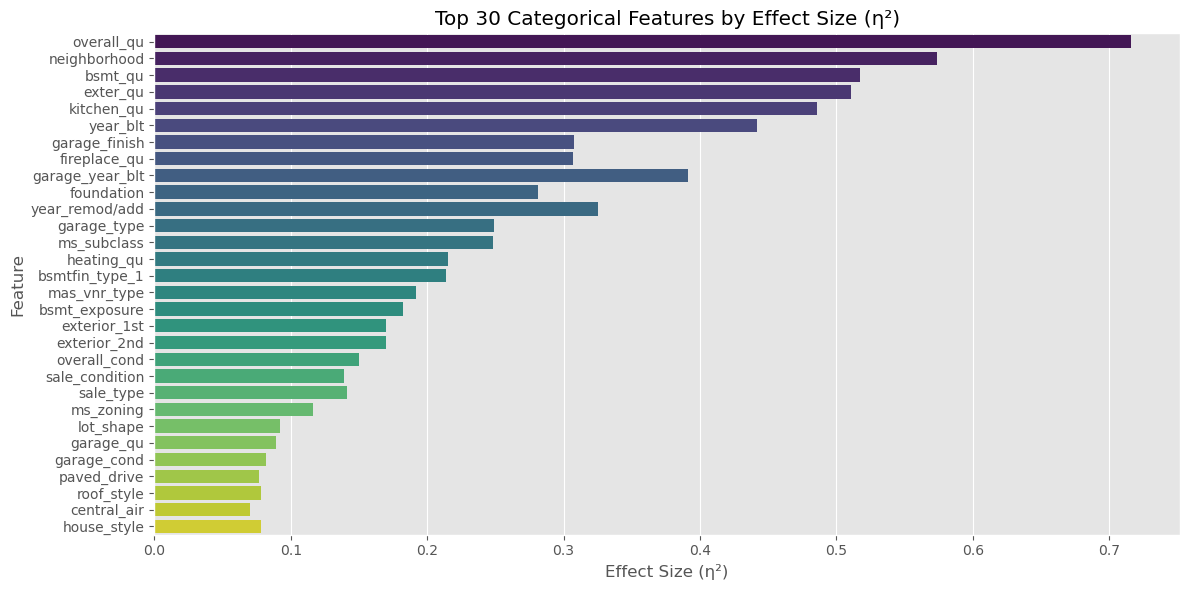

In [437]:
anova_categorical_feature_importance(df, nominal + ordinal, top_n=30)

Cramér's V is a measure of association between two nominal variables, giving a value between 0 and 1.
It is based on the chi-squared statistic and provides insight into the strength of the relationship between categorical features.
The formula for Cramér's V is:
V = sqrt(χ² / (n * (k - 1)))
where:
- χ² is the chi-squared statistic,
- n is the total number of observations,
- k is the minimum number of categories in either variable.

In the function `plot_cramer_v_associations`, we calculate Cramér's V for each pair of categorical features.
We first generate all possible pairs of categorical features and then compute the chi-squared statistic for each pair.
Using the chi-squared statistic, we calculate Cramér's V to measure the strength of association.
Finally, we plot the top 30 pairs with the highest Cramér's V values to visualize the strongest associations.

This measure helps identify pairs of categorical features that are strongly associated, which can be useful for feature engineering and reducing redundancy in the dataset.


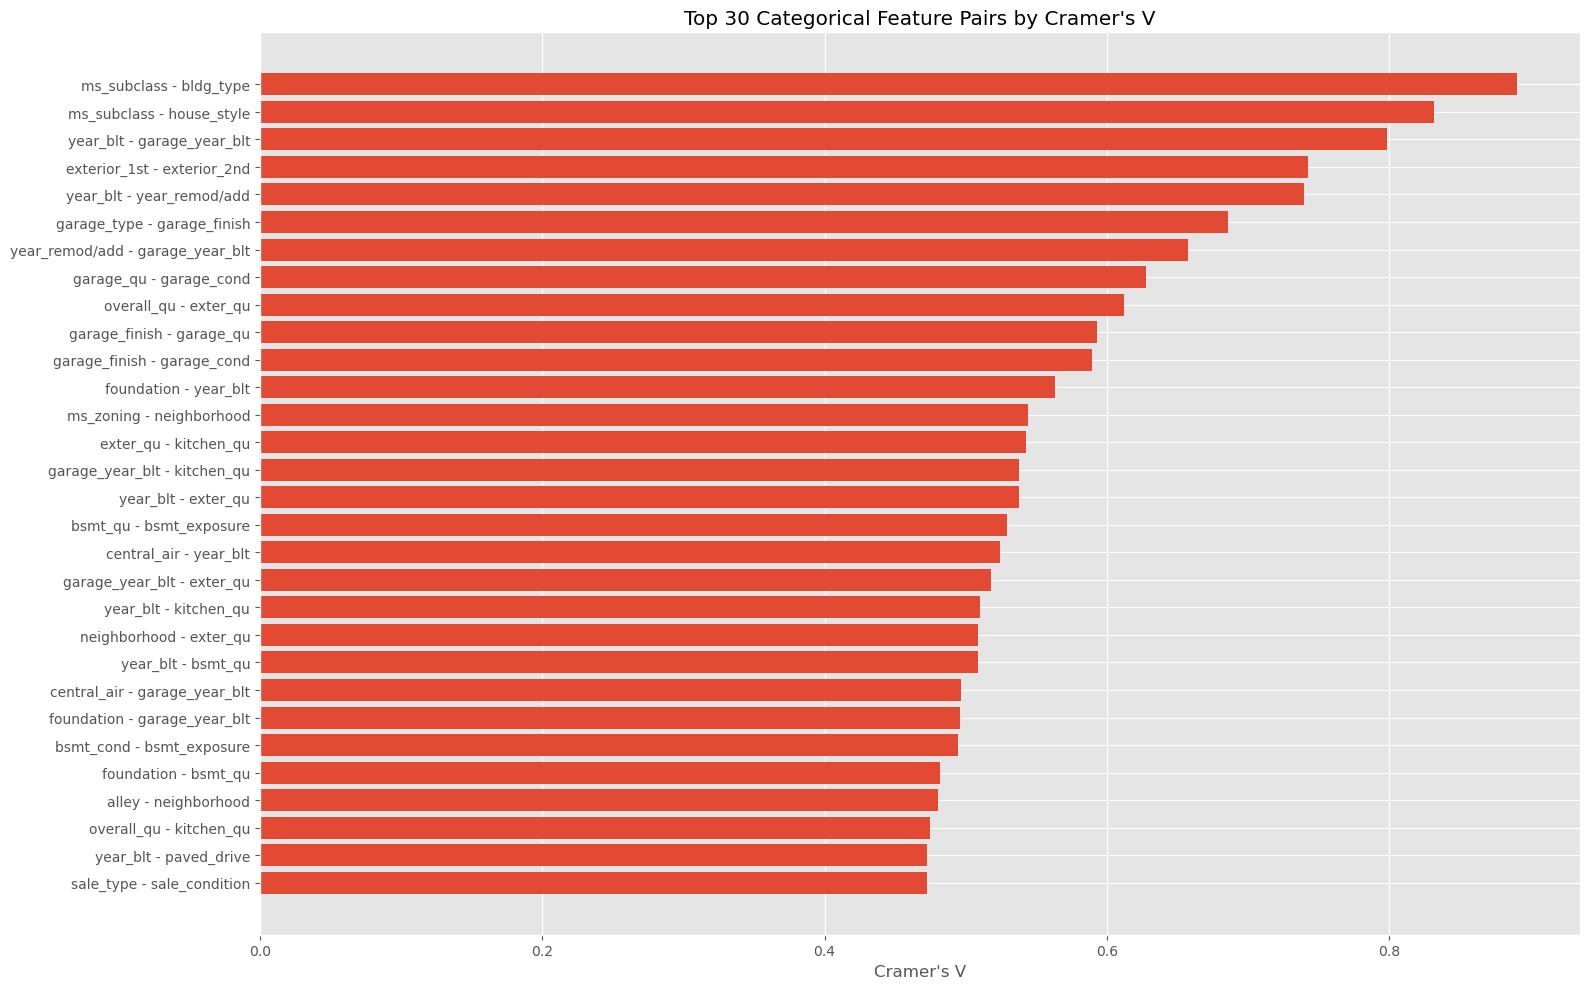

In [438]:
# Call function with combined categorical features
plot_cramer_v_associations(df, nominal + ordinal, top_n=30)

#### Observations and Insights

From the **Top 10 Categorical Features by Effect Size (η²)** chart, features like `overall_qu`, `neighborhood`, `bsmt_qu`, and `exter_qu` stand out with high explanatory power for the target variable. These features are likely critical for model performance.

The **Cramér's V analysis** highlights several strongly correlated pairs, such as `ms_subclass` with `bldg_type` or `house_style` (building class and building/house type). Given that `ms_subclass` is a useful feature, we may simply consider dropping the other two, as a domain understanding of the data shows that these tend to indicate the very same thing. Similarly for `year_blt` and `garage_year_blt` (potentially for our imputing strategy for 153 observations only) but very strong correlation for `year_remod/add` also.

Similarly, we should consider `garage_type` with `garage_finish` as well as `garage_finish` with `garage_qu` and `garage_cond` (both of which are useful for predicting price). Hence, it is reasonable to consider dropping `garage_finish` for preliminary feature selection based on a simple understanding of what the variable tends to capture because `garage_finish` is just about the interior finish of the garage, which should already be captured in its quality and condition. These correlations suggest possible redundancies, or some features on basement condition and quality with types are very highly correlated. We can use this for feature engineering and construct an aggregate measure of basement instead of individually correlated ones.

Similarly, `bsmtfin_type_1` and `bsmtfin_type_2` are qualities of the basement finished area and are very correlated with `bsmt_qu`, `bsmt_cond`.

Though `neighbourhood` is a good feature and supposedly we always think that it will be for sure a factor to affect the price. However, it is clearly very correlated with the general zoning classification of the sale `mszoning` (i.e. it may not matter too much the neighbourhood name if it is a certain residential area), and it also correlates with quality of basement, exterior, kitchen, garage and foundation details of the building. Note that we have 28 neighbourhoods areas and it is possible that conditional on building types, access, just adding dummies for each neighbourhood will not be particularly useful. We can think of making a new feature based on neighbourhood maybe.

Let's take a closer look at `neighbourhood` and `mszoning`. 

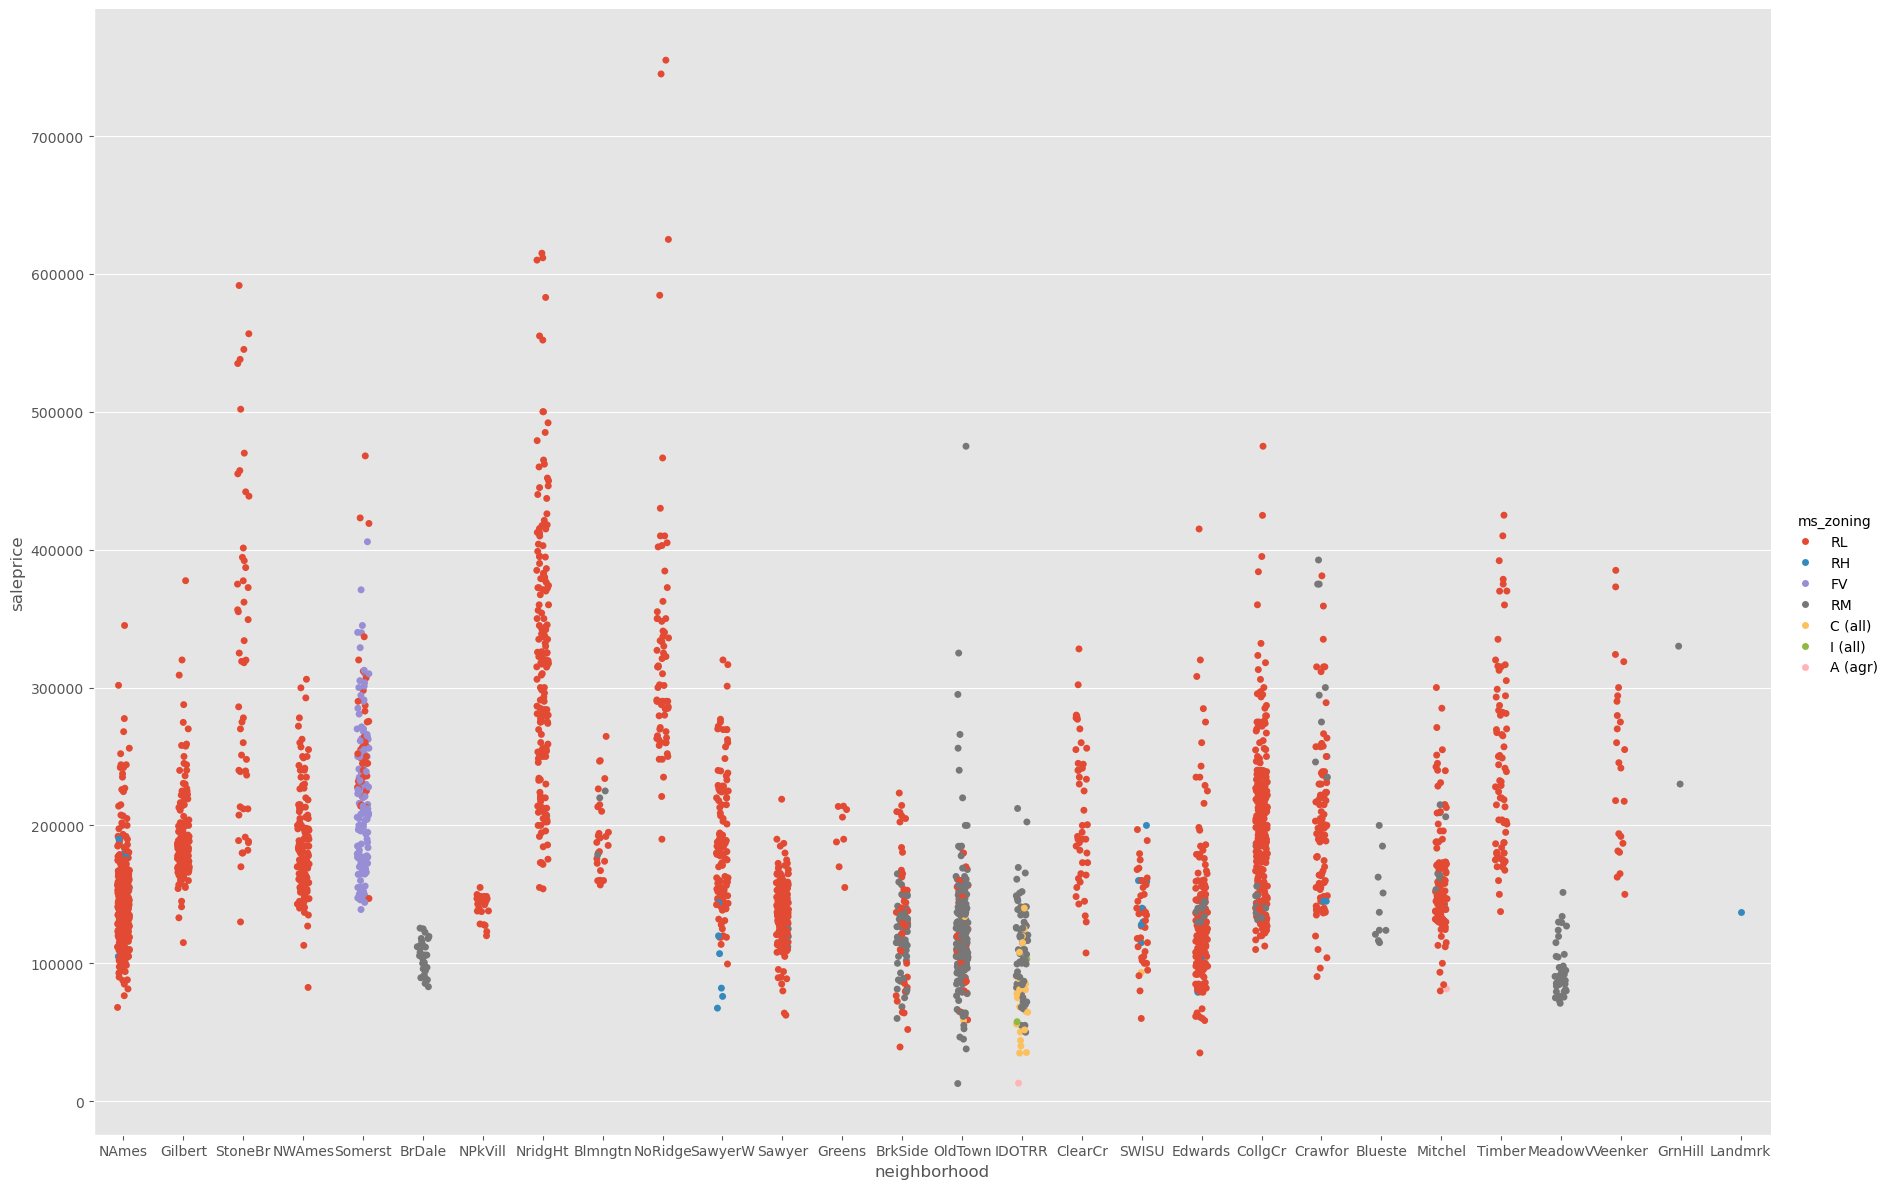

In [439]:
# Swarming Catplot FTW
fig = sns.catplot(x='neighborhood', y='saleprice', hue='ms_zoning', data=df, kind='strip', height=12, aspect=1.5)
ax = fig.axes[0][0]
plt.show()

It makes sense now that mszoning correlates a lot with neighbourhood because in it has residential area classified also based on population density with low to high, which should aready be part of the information contained in the neighbourhood itself. Therefore, given that we may keep the neighbourhood feature, we may consider aggregate 'RL', 'RH', 'RM' into one category of residential when training the GLM.

# 7. Closer look at numerical features

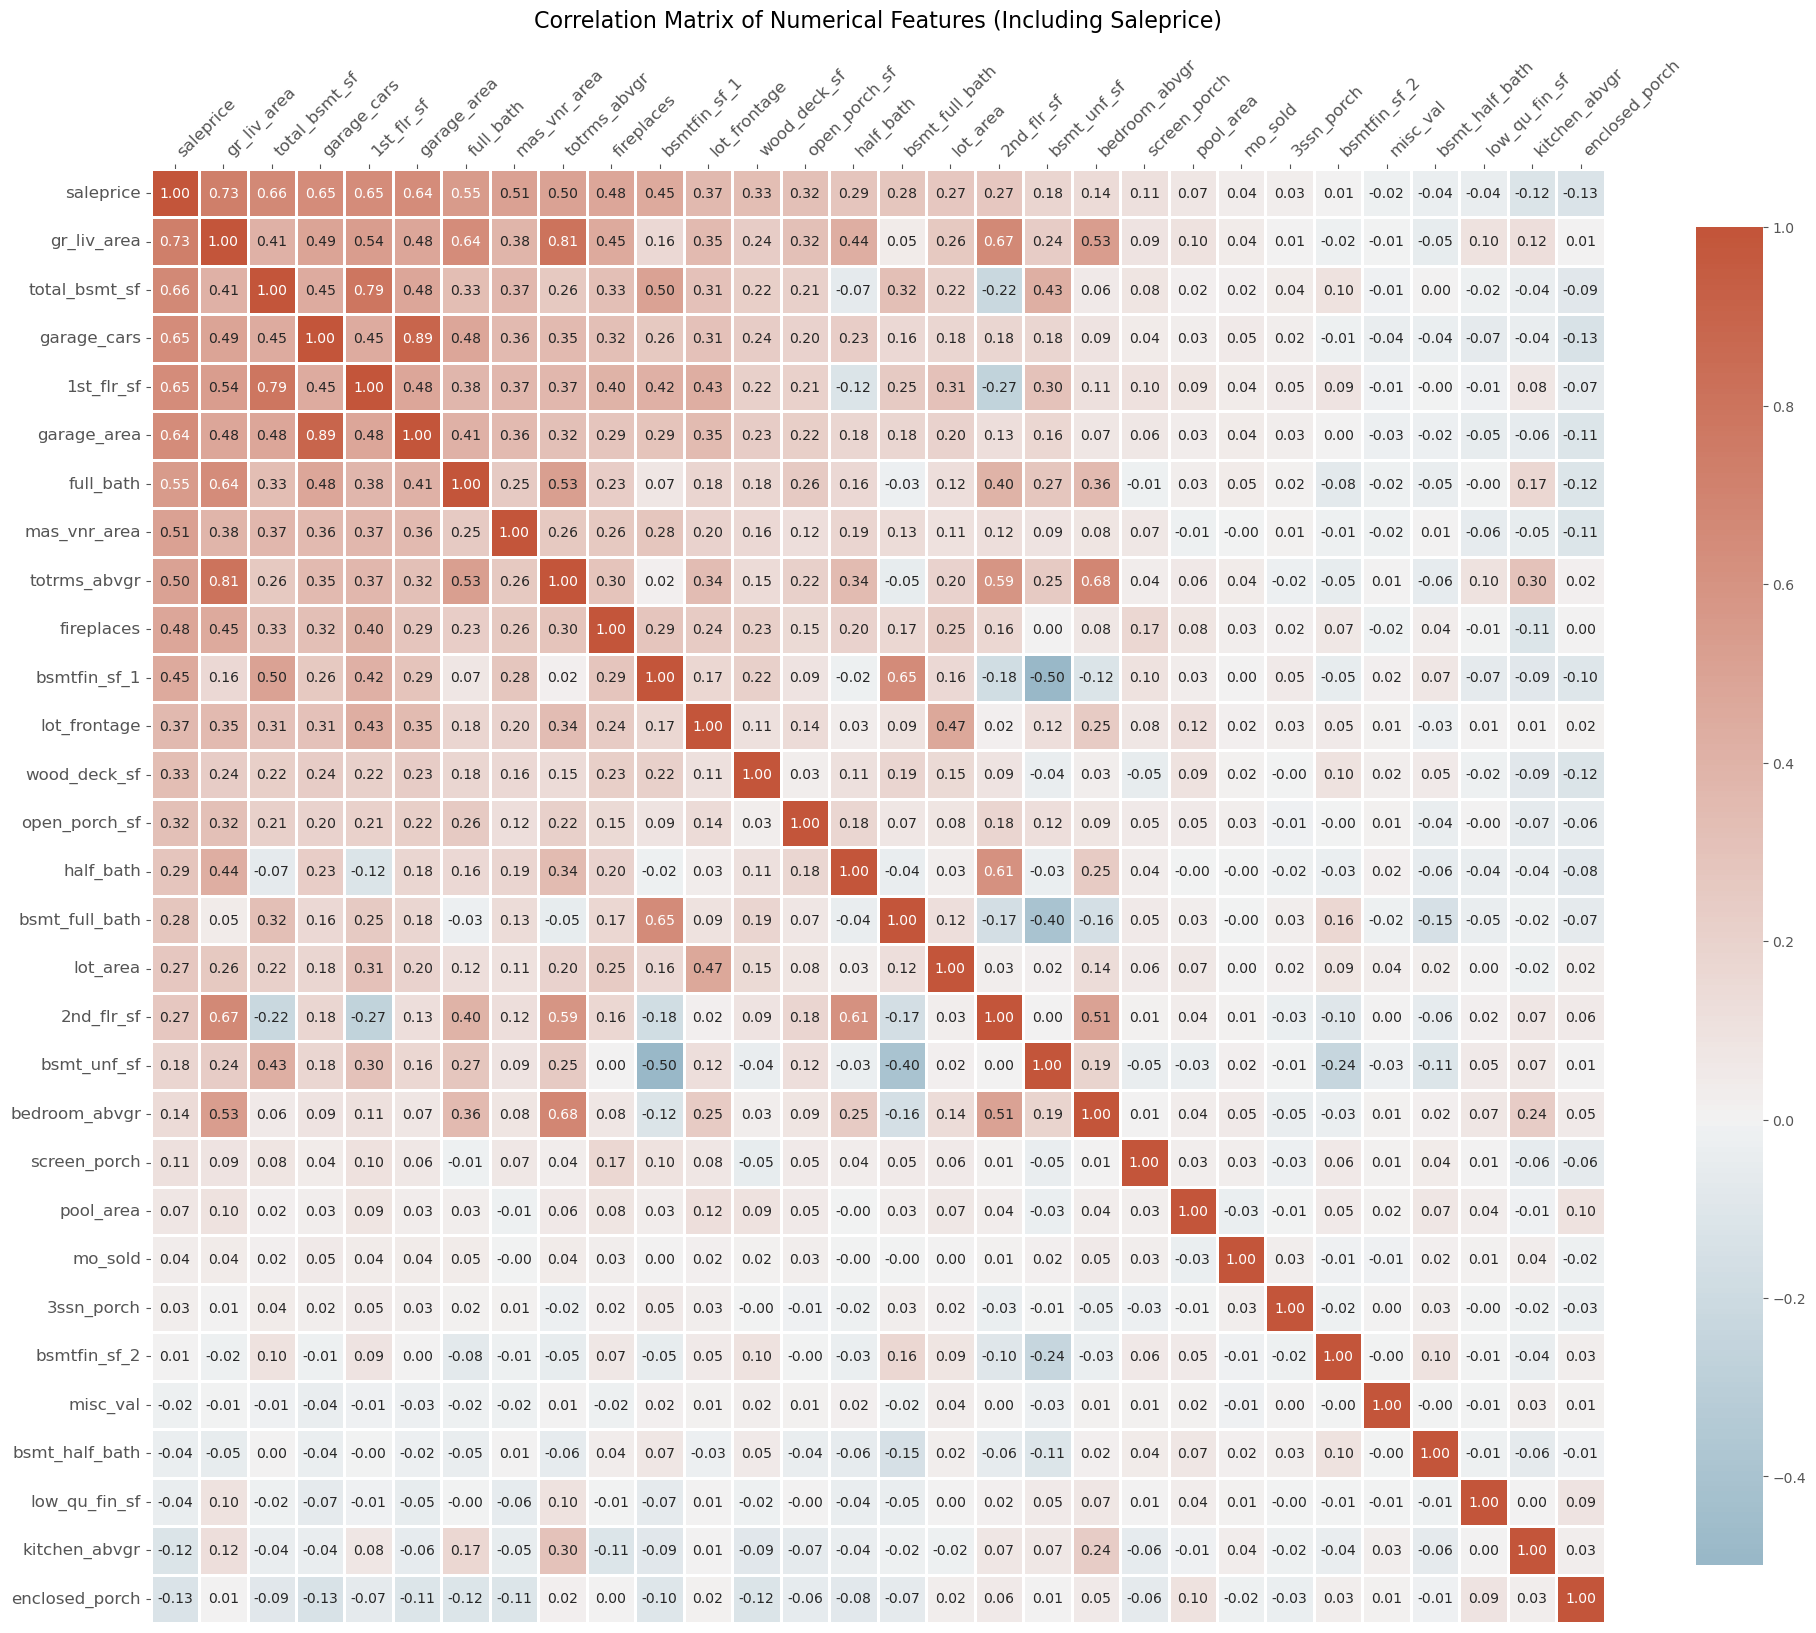

In [440]:
plot_numerical_correlation_matrix(df, target='saleprice', numerical_cols=continuous + discrete)


Features like gr_liv_area, total_bsmt_sf, garage_cars, garage_area, and 1st_flr_sf seem to have strong positive correlations with `saleprice`, but also very correlated with each other as they all indicate house size. That is features useful for predicting house size also seem to be very highly correlated with each other. 

Especially, `garage_cars` and `garage_area` are redundant because they both represent the size of the garage.

Suprisingly, `fullbath` (full bathrooms above grade) also very strongly correlated with `saleprice`, but also with living area. Unfinished square feet of basement area clearly will correlate very negatively with finished square feet of basement area `bsmt_fin_sf1`. 

Features like `enclosed_porch`, `misc_val`, and `pool_area` show weak correlation with `saleprice`, potentially due to the lack of variations. But for `misc_val`, given the very diverse range of different kind of added facilities as discussed in misc. 

# 8. Summary of Cleaning and Formatting Steps

**Steps- Data Cleaning**

1. **Reformat Column Names**  - implicitly done in the `preliminary_loader`
   - **Objective:** Clean column names for consistency.
   - **Action:**  
     - Remove spaces from column names.
     - Convert all column names to lowercase.
     - Ensure consistent naming (e.g., no underscores, standard abbreviations).

2. **Outlier Removal**  
   - **Objective:** Remove rows with outliers.
   - **Action:**  
     - Drop rows where `gr_liv_area > 4000` and `saleprice < 200000`.

3. **Missing Values Imputation:**
   - **Objective:** Fill missing values based on predefined strategies.
   - **Actions:**  
     - **Keywords-Based Filling:** Use the function `simple_fill_missing_by_keywords()` to fill in missing values for the following columns using dictionary-based (and further exploration) information:  
       `['pool', 'bsmt', 'fence', 'fireplace', 'alley', 'misc_feature', 'mas_vnr']`
     - **Electrical Column Imputation:** Fill missing values in the `electrical` column with `'SBrkr'` (based on common electrical type for similar properties in the area).
     - **Garage Information Imputation:** Use the `garage_imputer()` function to fill missing garage-related information.
     - **Motivating Lot Frontage Imputation in the pipeline after train/test split (not done here):** Fill missing `lot_frontage` values with the **median** value of properties that share the same `neighborhood` and `lot_config` (assuming similar lot characteristics across the neighborhood).

4. **Type Formatting:**
   - Correct the format of values and data types for consistency based on ordinal, normial, discrete, continuous data types; standardize the format of values in ordinal variables based on the dictionary information (given in config). 

All this is done when you run the `integration_scipts/load_and_clean.py` directly from the terminal. It will give you a copy of the cleaned data in the `_cleanfile` folder (apart from imputing `lot_frontage`). 

# 9. Summary of EDA Insights on Features and Outcome Distribution

The target `saleprice` is skewed and has fat-tailed. In prediction tasks, we may then use an objective function that is robust to outliers, such as Huber loss for LGBM and the Gamma distribution for GLM (especially given the shape and non-negative nature of the data).

Numerical variables shows a lot of skewed distribution, while categorical variables shows a lot of imbalance. Hence, it is a feature of the data that can be useful for modelling, and lightGBM can take care of this information directly. However, for GLM, we may want to use a winsorizer and robust scaler to mitigate the impact of outliers. 

# 10. Summary of EDA Insights on Feature Engineering and Selection

We can already directly drop some features that are highly correlated with each other or contain redundant information: `garage_year_blt`, `garage_cars`, `bldg_type`, `house_style`. This is saved in `config.yaml` for the record and reuse. 

Adding some aggregated features like: total area of the house, percentage of finished basement area, percentage of half baths, timing of the remodelling relative to the year built and year sold. 

We can also better capture some interactions between quality features, by some aggregate measures of them, as that might indicate they score well in some but not some well in others. This is not perfect but it is a good start than introducing numerous interaction terms given the amount of ordinal variables we have as this can indicate an overall feeling of the buyers for the quality of interiors or exteriors separately.



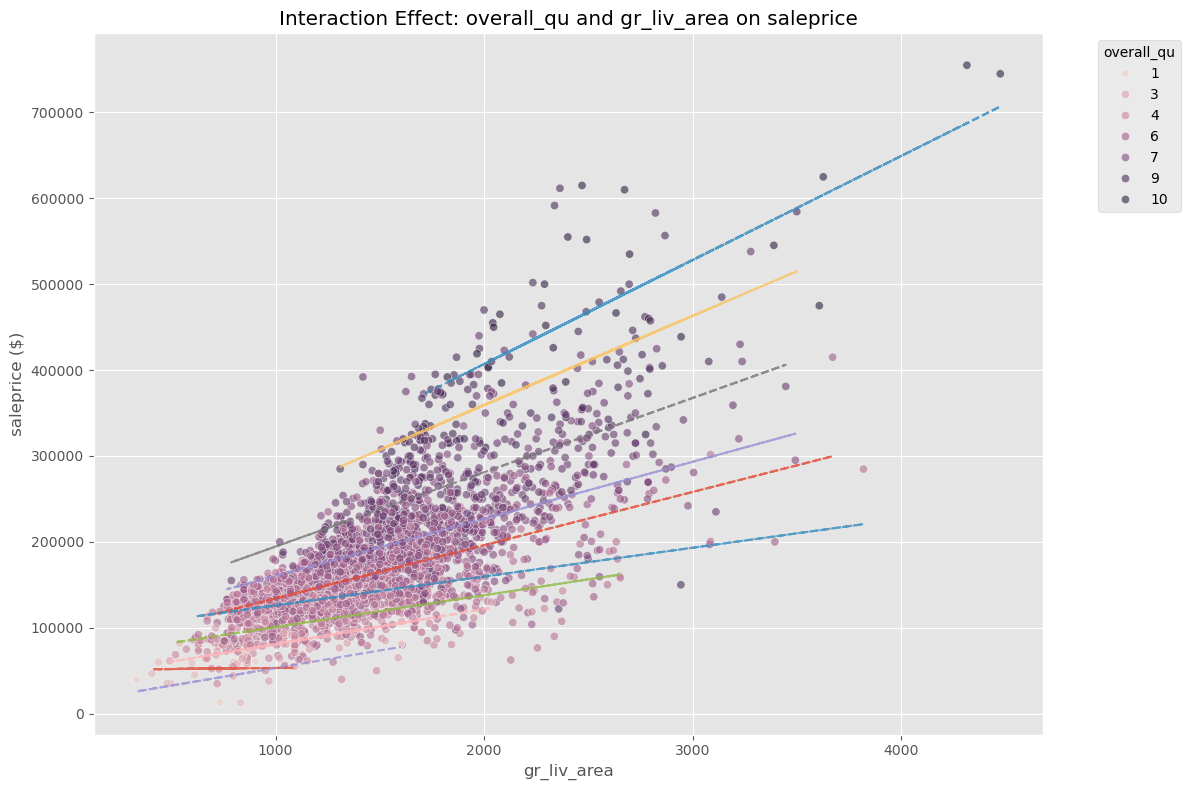

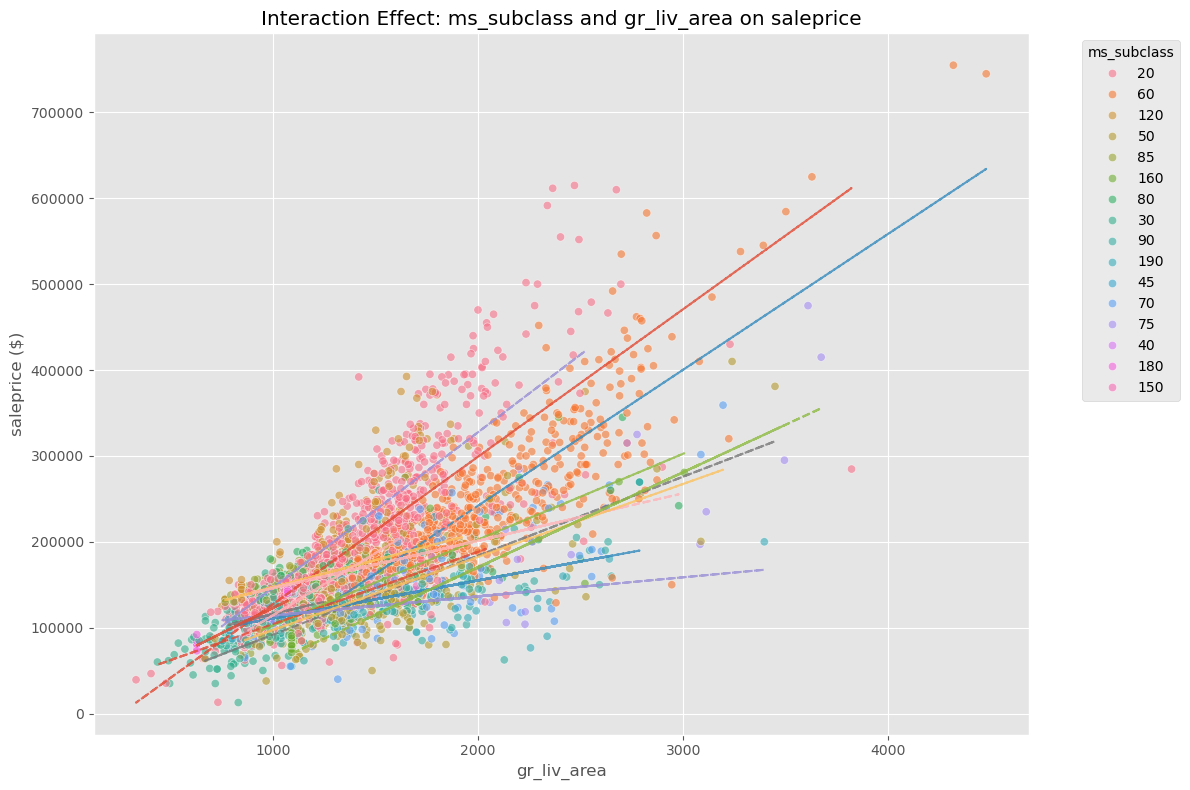

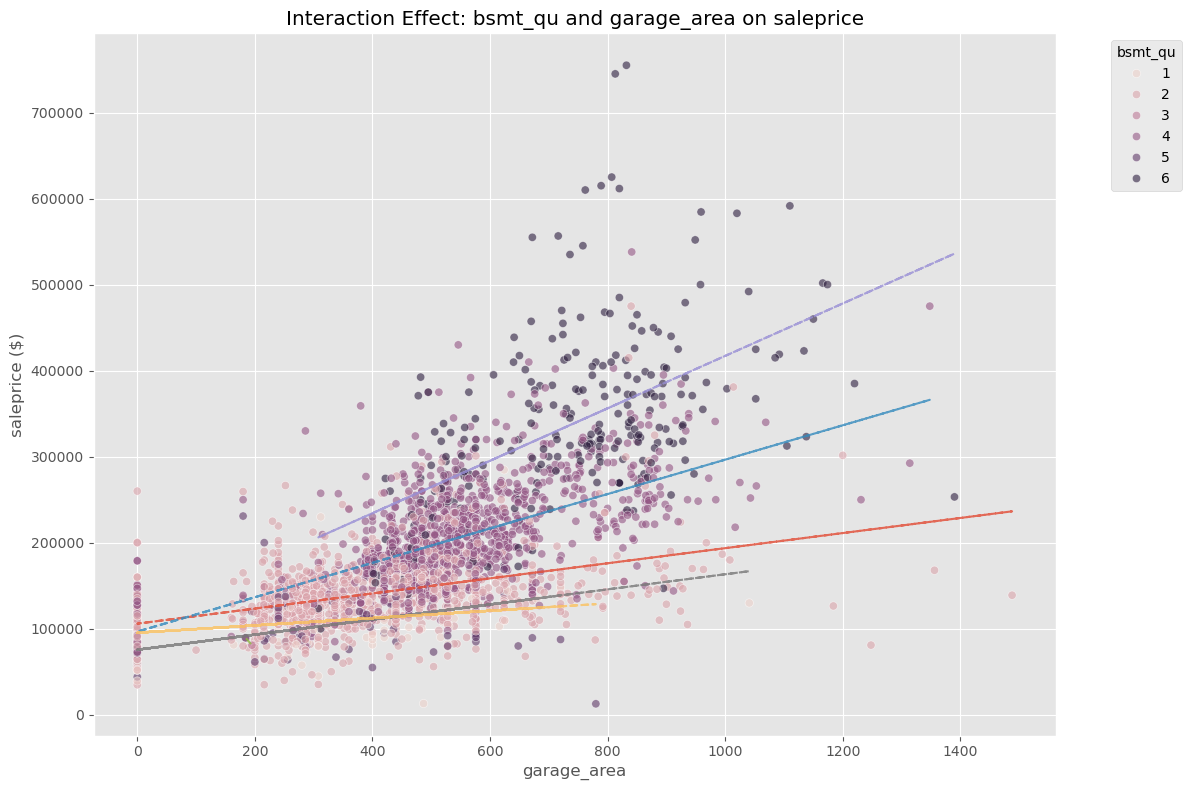

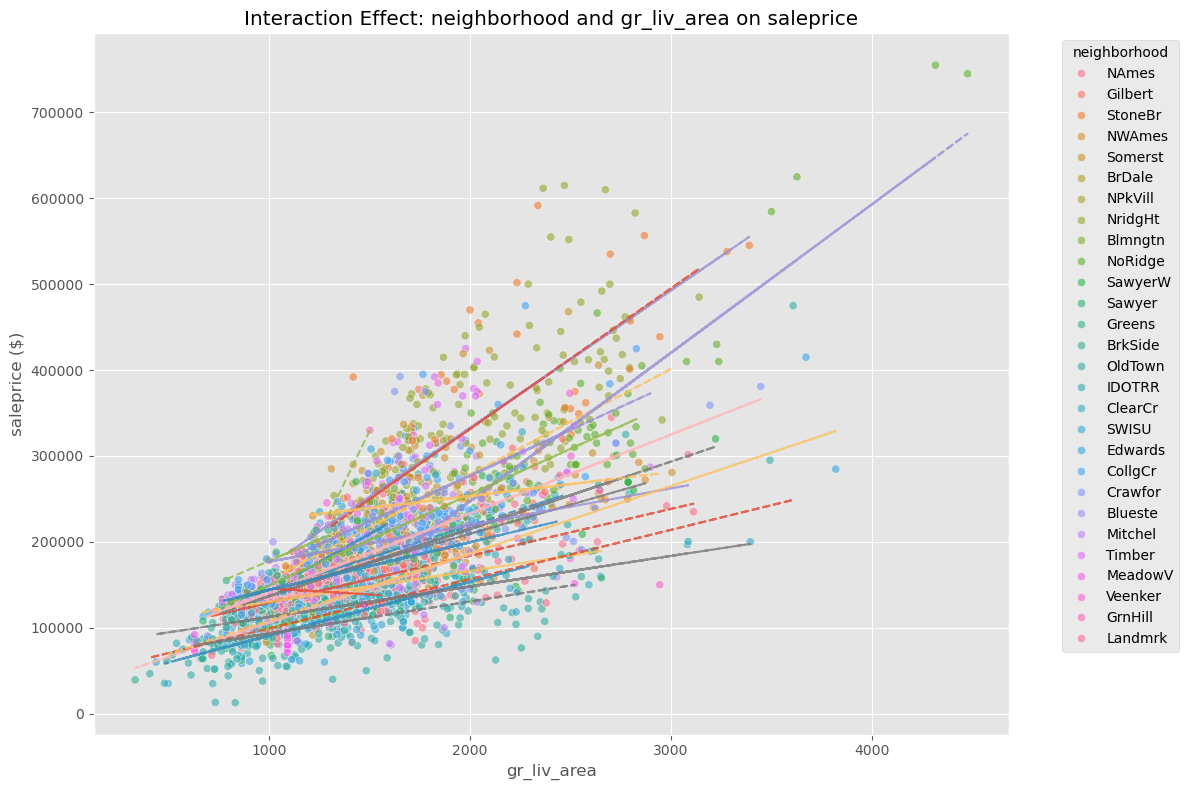

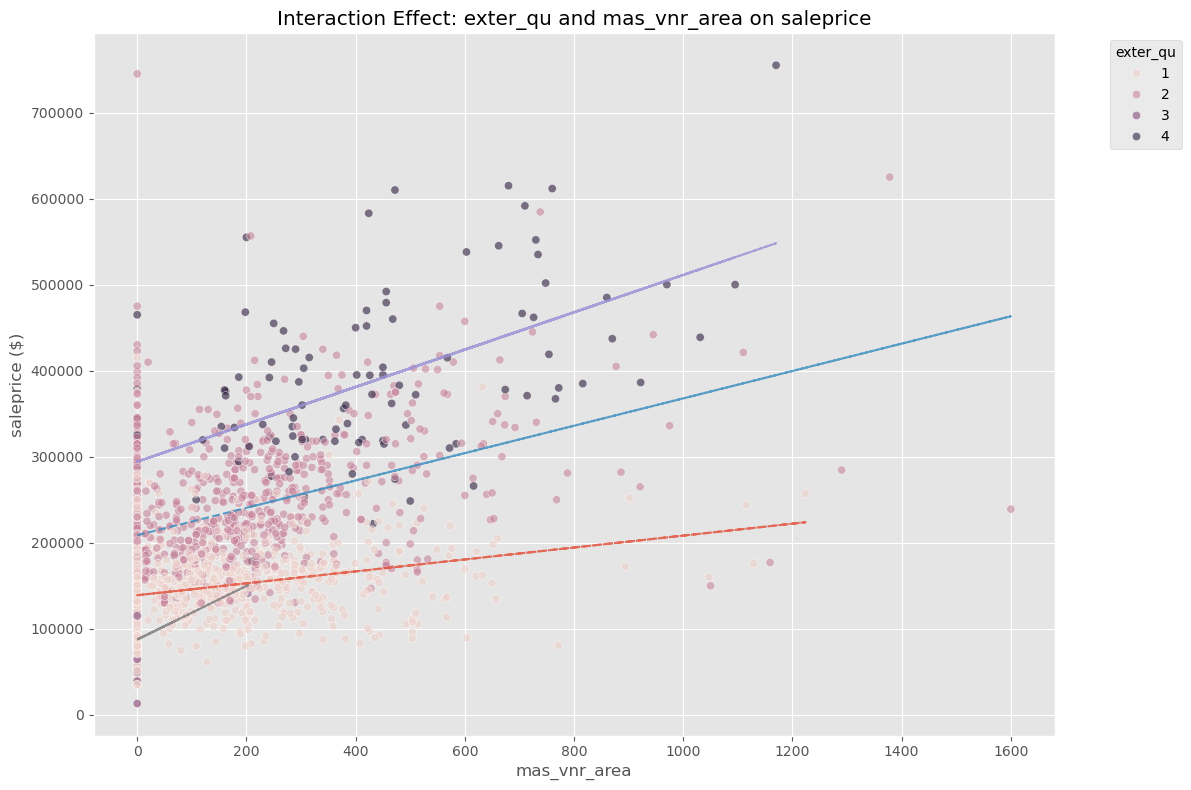

In [467]:
import pandas as pd
def plot_interaction_effect(df, numerical_col, categorical_col, target_col='saleprice'):
    """
    Plot interaction effect between a numerical and categorical variable on a target variable.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the data
    numerical_col : str
        Name of numerical column to plot on x-axis
    categorical_col : str 
        Name of categorical column to use for coloring
    target_col : str, default='saleprice'
        Name of target variable to plot on y-axis
        
    Raises:
    -------
    ValueError
        If input df is not a pandas DataFrame
        If any of the specified columns don't exist in df
        If numerical_col contains non-numeric data
    """
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input df must be a pandas DataFrame")
        
    for col in [numerical_col, categorical_col, target_col]:
        if col not in df.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
            
    if not np.issubdtype(df[numerical_col].dtype, np.number):
        raise ValueError(f"Column {numerical_col} must contain numeric data")
    
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot
    sns.scatterplot(data=df, x=numerical_col, y=target_col, 
                   hue=categorical_col, alpha=0.6)
    
    # Add regression line for each category
    for category in df[categorical_col].unique():
        subset = df[df[categorical_col] == category]
        if len(subset) > 1:  # Need at least 2 points for regression
            z = np.polyfit(subset[numerical_col], subset[target_col], 1)
            p = np.poly1d(z)
            plt.plot(subset[numerical_col], p(subset[numerical_col]), 
                    linestyle='--', alpha=0.8)
    
    plt.title(f'Interaction Effect: {categorical_col} and {numerical_col} on {target_col}')
    plt.xlabel(f'{numerical_col}')
    plt.ylabel(f'{target_col} ($)')
    plt.legend(title=categorical_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Call the function
plot_interaction_effect(df, 'gr_liv_area', 'overall_qu')
plot_interaction_effect(df, 'gr_liv_area', 'ms_subclass')
plot_interaction_effect(df, 'garage_area', 'bsmt_qu')
plot_interaction_effect(df, 'gr_liv_area', 'neighborhood')
plot_interaction_effect(df, 'mas_vnr_area', 'exter_qu')
